### Dice Coefficient

In [28]:
# FC and PPI dice coefficient for Experiment 2
import os
import numpy as np
import pandas as pd
import nibabel as nib
from scipy import stats

# Define study directories
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info_tool.csv'  # Updated for exp 2
output_dir = f'{results_dir}/exp2_dice_comparison'  # New directory for exp 2
os.makedirs(output_dir, exist_ok=True)

def dice_coefficient(img1_data, img2_data):
    """Calculate Dice coefficient between two binary arrays."""
    # Ensure binary
    img1_bin = (img1_data > 0).astype(int)
    img2_bin = (img2_data > 0).astype(int)
    
    # Calculate intersection
    intersection = np.sum(img1_bin * img2_bin)
    
    # Calculate Dice using formula: 2*intersection/(sum of elements)
    dice = 2.0 * intersection / (np.sum(img1_bin) + np.sum(img2_bin))
    
    return dice

def analyze_data_type(analysis_type, condition='tools'):
    """Analyze dice coefficients for a specific data type (fc or ppi) and condition"""
    print(f"\n{'='*80}")
    print(f"ANALYZING {analysis_type.upper()} MAPS FOR {condition.upper()} CONDITION")
    print(f"{'='*80}")
    
    # Load subject info - updated for exp 2
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()
    print(f"Found {len(subjects)} subjects")
    
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']  # Focusing on these ROIs for exp 2
    hemispheres = ['left', 'right']
    
    # Load and preprocess subject data
    subject_data = {}
    valid_subjects = []
    
    for sub in subjects:
        has_all_data = True
        subject_data[sub] = {}
        
        for roi in rois:
            # Initialize lists to store hemisphere data
            roi_data_arrays = []
            
            for hemi in hemispheres:
                # Update file path pattern for exp 2
                if condition == 'tools':
                    roi_file = f'{study_dir}/{sub}/ses-01/derivatives/{analysis_type}/mni/{sub}_{roi}_{hemi}_ToolLoc_{analysis_type}_mni.nii.gz'
                else:  # nontools
                    roi_file = f'{study_dir}/{sub}/ses-01/derivatives/{analysis_type}/mni/{sub}_{roi}_{hemi}_{condition}_ToolLoc_{analysis_type}_mni.nii.gz'
                
                if os.path.exists(roi_file):
                    try:
                        img = nib.load(roi_file)
                        roi_data_arrays.append(img.get_fdata())
                    except Exception as e:
                        print(f"Error loading {roi_file}: {e}")
                        has_all_data = False
                else:
                    print(f"File not found: {roi_file}")
                    has_all_data = False
            
            # Average the hemispheres if we have data for both
            if len(roi_data_arrays) == 2:
                # Create averaged map
                avg_data = (roi_data_arrays[0] + roi_data_arrays[1]) / 2
                subject_data[sub][roi] = avg_data
            else:
                has_all_data = False
        
        if has_all_data:
            valid_subjects.append(sub)
    
    print(f"Found {len(valid_subjects)} subjects with complete {analysis_type} data for {condition} condition")
    
    if len(valid_subjects) == 0:
        print(f"No valid subjects found for {analysis_type} analysis. Skipping.")
        return None
    
    # 1. Within-subject, between-ROI analysis (pIPS vs LO)
    print(f"\nCalculating within-subject, between-ROI dice coefficients for {analysis_type}...")
    between_roi_results = []
    
    for sub in valid_subjects:
        try:
            # Calculate Dice coefficient
            dice_score = dice_coefficient(subject_data[sub]['pIPS'], subject_data[sub]['LO'])
            
            between_roi_results.append({
                'Subject': sub,
                'Analysis': analysis_type,
                'Condition': condition,
                'Dice': dice_score
            })
            
            print(f"Subject {sub}, {analysis_type}, {condition}, pIPS vs LO: {dice_score:.4f}")
        except Exception as e:
            print(f"Error processing subject {sub}: {e}")
    
    # Convert to DataFrame
    between_roi_df = pd.DataFrame(between_roi_results)
    
    # Calculate statistics
    mean = between_roi_df['Dice'].mean()
    std = between_roi_df['Dice'].std()
    # 95% confidence interval
    ci = stats.t.interval(0.95, len(between_roi_df)-1, loc=mean, scale=std/np.sqrt(len(between_roi_df)))
    
    print(f"\n{analysis_type.upper()}, {condition.upper()}: pIPS vs LO within-subject similarity:")
    print(f"Mean Dice: {mean:.4f} ± {std:.4f}")
    print(f"95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")
    print(f"N = {len(between_roi_df)} subjects")
    
    # 2. Between-subject, within-ROI analysis
    print(f"\nCalculating between-subject, within-ROI dice coefficients for {analysis_type}...")
    within_roi_results = []
    
    for roi in rois:
        # Compare each subject to all others
        for i, sub1 in enumerate(valid_subjects):
            for j, sub2 in enumerate(valid_subjects):
                if i < j:  # Only compare each pair once
                    try:
                        # Calculate Dice coefficient
                        dice_score = dice_coefficient(subject_data[sub1][roi], subject_data[sub2][roi])
                        
                        within_roi_results.append({
                            'ROI': roi,
                            'Analysis': analysis_type,
                            'Condition': condition,
                            'Subject1': sub1,
                            'Subject2': sub2,
                            'Dice': dice_score
                        })
                    except Exception as e:
                        print(f"Error comparing {sub1} and {sub2} for {roi}: {e}")
    
    # Convert to DataFrame
    within_roi_df = pd.DataFrame(within_roi_results)
    
    # Calculate statistics for each ROI
    within_roi_stats = []
    
    for roi in rois:
        roi_data = within_roi_df[within_roi_df['ROI'] == roi]
        
        if len(roi_data) > 0:
            mean = roi_data['Dice'].mean()
            std = roi_data['Dice'].std()
            # 95% confidence interval
            ci = stats.t.interval(0.95, len(roi_data)-1, loc=mean, scale=std/np.sqrt(len(roi_data)))
            
            within_roi_stats.append({
                'ROI': roi,
                'Analysis': analysis_type,
                'Condition': condition,
                'Mean Dice': mean,
                'Std Dev': std,
                '95% CI Lower': ci[0],
                '95% CI Upper': ci[1],
                'N': len(roi_data)
            })
            
            print(f"\n{analysis_type.upper()}, {condition.upper()}: {roi} between-subject similarity:")
            print(f"Mean Dice: {mean:.4f} ± {std:.4f}")
            print(f"95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")
            print(f"Based on {len(roi_data)} comparisons among {len(valid_subjects)} subjects")
    
    # Save results to CSV files
    between_roi_df.to_csv(f'{output_dir}/{analysis_type}_{condition}_between_roi_dice_by_subject.csv', index=False)
    within_roi_df.to_csv(f'{output_dir}/{analysis_type}_{condition}_within_roi_dice_by_pair.csv', index=False)
    
    within_roi_stats_df = pd.DataFrame(within_roi_stats)
    within_roi_stats_df.to_csv(f'{output_dir}/{analysis_type}_{condition}_within_roi_stats.csv', index=False)
    
    # Prepare summary data
    between_roi_stats = {
        'ROI': 'pIPS vs LO',
        'Analysis': analysis_type,
        'Condition': condition,
        'Mean Dice': between_roi_df['Dice'].mean(),
        'Std Dev': between_roi_df['Dice'].std(),
        '95% CI Lower': ci[0],
        '95% CI Upper': ci[1],
        'N': len(between_roi_df)
    }
    
    # Combine all stats into one DataFrame
    all_stats = pd.DataFrame([between_roi_stats] + within_roi_stats)
    
    return {
        'between_roi': between_roi_df,
        'within_roi': within_roi_df,
        'stats': all_stats
    }

def main():
    """Analyze both FC and PPI data for tools and nontools conditions"""
    results = {}
    all_stats = []
    
    # Analyze tools condition
    for analysis_type in ['fc', 'ppi']:
        print(f"\nAnalyzing {analysis_type.upper()} data for tools condition...")
        tools_results = analyze_data_type(analysis_type, 'tools')
        if tools_results:
            results[f'{analysis_type}_tools'] = tools_results
            all_stats.append(tools_results['stats'])
    
    # Analyze nontools condition
    for analysis_type in ['fc', 'ppi']:
        print(f"\nAnalyzing {analysis_type.upper()} data for nontools condition...")
        nontools_results = analyze_data_type(analysis_type, 'nontools')
        if nontools_results:
            results[f'{analysis_type}_nontools'] = nontools_results
            all_stats.append(nontools_results['stats'])
    
    # Combine stats from all analyses
    if all_stats:
        combined_stats = pd.concat(all_stats)
        combined_stats.to_csv(f'{output_dir}/combined_dice_stats.csv', index=False)
        
        # Print combined summary
        print("\n\nCOMBINED SUMMARY OF DICE COEFFICIENT ANALYSES")
        print("=" * 80)
        print(combined_stats.to_string(index=False))
        
        # Create comparison table for FC vs PPI (for each condition)
        for condition in ['tools', 'nontools']:
            condition_stats = combined_stats[combined_stats['Condition'] == condition]
            if len(condition_stats) > 0:
                comparison = condition_stats.pivot(index='ROI', columns='Analysis', values='Mean Dice')
                if 'fc' in comparison.columns and 'ppi' in comparison.columns:
                    comparison['Difference'] = comparison['ppi'] - comparison['fc']
                    
                    print(f"\n\n{condition.upper()}: FC vs PPI COMPARISON")
                    print("=" * 80)
                    print(comparison.to_string())
                    
                    comparison.to_csv(f'{output_dir}/{condition}_fc_vs_ppi_comparison.csv')
        
        # Create comparison table for tools vs nontools (for each analysis type)
        for analysis_type in ['fc', 'ppi']:
            analysis_stats = combined_stats[combined_stats['Analysis'] == analysis_type]
            if len(analysis_stats) > 0:
                comparison = analysis_stats.pivot(index='ROI', columns='Condition', values='Mean Dice')
                if 'tools' in comparison.columns and 'nontools' in comparison.columns:
                    comparison['Difference'] = comparison['tools'] - comparison['nontools']
                    
                    print(f"\n\n{analysis_type.upper()}: TOOLS vs NONTOOLS COMPARISON")
                    print("=" * 80)
                    print(comparison.to_string())
                    
                    comparison.to_csv(f'{output_dir}/{analysis_type}_tools_vs_nontools_comparison.csv')
    
    return results

if __name__ == "__main__":
    results = main()


Analyzing FC data for tools condition...

ANALYZING FC MAPS FOR TOOLS CONDITION
Found 18 subjects


Found 18 subjects with complete fc data for tools condition

Calculating within-subject, between-ROI dice coefficients for fc...
Subject sub-spaceloc1001, fc, tools, pIPS vs LO: 0.8790
Subject sub-spaceloc1002, fc, tools, pIPS vs LO: 0.8682
Subject sub-spaceloc1003, fc, tools, pIPS vs LO: 0.9543
Subject sub-spaceloc1004, fc, tools, pIPS vs LO: 0.9038
Subject sub-spaceloc1005, fc, tools, pIPS vs LO: 0.9496
Subject sub-spaceloc1006, fc, tools, pIPS vs LO: 0.9470
Subject sub-spaceloc1007, fc, tools, pIPS vs LO: 0.9354
Subject sub-spaceloc1008, fc, tools, pIPS vs LO: 0.9340
Subject sub-spaceloc1009, fc, tools, pIPS vs LO: 0.9016
Subject sub-spaceloc1010, fc, tools, pIPS vs LO: 0.9504
Subject sub-spaceloc1011, fc, tools, pIPS vs LO: 0.8642
Subject sub-spaceloc1012, fc, tools, pIPS vs LO: 0.9703
Subject sub-spaceloc2013, fc, tools, pIPS vs LO: 0.9497
Subject sub-spaceloc2014, fc, tools, pIPS vs LO: 0.9731
Subject sub-spaceloc2015, fc, tools, pIPS vs LO: 0.9515
Subject sub-spaceloc2016, fc, t

In [2]:
# FC and PPI ANOVA dice coefficient for Experiment 2
import os
import numpy as np
import pandas as pd
import nibabel as nib
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.stats.multitest import multipletests

def compare_within_vs_between_dice_anova_averaged(analysis_type='fc', condition='tools'):
    """
    Independent function to compare within-ROI vs between-ROI dice coefficients 
    using ANOVA with subject-level averages for better statistical properties.
    Now supports both FC and PPI analysis types, and tools/nontools conditions.
    
    Parameters:
    -----------
    analysis_type : str
        Type of analysis to perform, either 'fc' or 'ppi'
    condition : str
        Condition to analyze, either 'tools' or 'nontools'
    """
    # Define study directories for Experiment 2
    study_dir = "/lab_data/behrmannlab/vlad/ptoc"
    results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
    sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info_tool.csv'  # Updated for Exp 2
    output_dir = f'{results_dir}/exp2_dice_comparison'
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Comparing within-ROI vs between-ROI dice coefficients using ANOVA with subject averages for {analysis_type.upper()} - {condition} condition...")
    
    # Load subject info for Experiment 2
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()  # Updated for Exp 2
    
    print(f"Found {len(subjects)} subjects")
    
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']  # Just these two ROIs for Exp 2
    hemispheres = ['left', 'right']
    
    # Load and preprocess subject data
    subject_data = {}
    valid_subjects = []
    
    for sub in subjects:
        has_all_data = True
        subject_data[sub] = {}
        
        for roi in rois:
            # Initialize lists to store hemisphere data
            roi_data_arrays = []
            
            for hemi in hemispheres:
                # Update file path for Experiment 2
                if condition == 'tools':
                    roi_file = f'{study_dir}/{sub}/ses-01/derivatives/{analysis_type}/mni/{sub}_{roi}_{hemi}_ToolLoc_{analysis_type}_mni.nii.gz'
                else:  # nontools
                    roi_file = f'{study_dir}/{sub}/ses-01/derivatives/{analysis_type}/mni/{sub}_{roi}_{hemi}_{condition}_ToolLoc_{analysis_type}_mni.nii.gz'
                
                if os.path.exists(roi_file):
                    try:
                        img = nib.load(roi_file)
                        roi_data_arrays.append(img.get_fdata())
                    except Exception as e:
                        print(f"Error loading {roi_file}: {e}")
                        has_all_data = False
                else:
                    print(f"File not found: {roi_file}")
                    has_all_data = False
            
            # Average the hemispheres if we have data for both
            if len(roi_data_arrays) == 2:
                # Create averaged map
                avg_data = (roi_data_arrays[0] + roi_data_arrays[1]) / 2
                subject_data[sub][roi] = (avg_data > 0).astype(int)  # Binarize
            else:
                has_all_data = False
        
        if has_all_data:
            valid_subjects.append(sub)
    
    print(f"Found {len(valid_subjects)} subjects with complete {analysis_type} data for {condition} condition")
    
    if len(valid_subjects) == 0:
        print(f"No valid subjects found for {analysis_type} analysis, {condition} condition. Skipping.")
        return None
    
    # 1. Within-subject, between-ROI analysis (pIPS vs LO)
    print(f"\nCalculating within-subject, between-ROI dice coefficients for {analysis_type} - {condition}...")
    between_roi_results = []
    
    for sub in valid_subjects:
        try:
            # Get binary maps
            pips_bin = subject_data[sub]['pIPS']
            lo_bin = subject_data[sub]['LO']
            
            # Calculate intersection
            intersection = np.sum(pips_bin * lo_bin)
            
            # Calculate Dice
            dice_score = 2.0 * intersection / (np.sum(pips_bin) + np.sum(lo_bin))
            
            between_roi_results.append({
                'Subject': sub,
                'Dice': dice_score,
                'Comparison': 'Within-subject_between-ROI'
            })
            
            print(f"Subject {sub}, pIPS vs LO: {dice_score:.4f}")
        except Exception as e:
            print(f"Error processing subject {sub}: {e}")
    
    # 2. Calculate all pairwise between-subject dice coefficients
    print(f"\nCalculating pairwise between-subject, within-ROI dice coefficients for {analysis_type} - {condition}...")
    pairwise_results = {}
    
    for roi in rois:
        pairwise_results[roi] = {}
        # Initialize the nested dictionary structure
        for sub in valid_subjects:
            pairwise_results[roi][sub] = {}
        
        # Compare each subject to all others
        for i, sub1 in enumerate(valid_subjects):
            for j, sub2 in enumerate(valid_subjects):
                if i < j:  # Only compare each pair once
                    try:
                        # Get binary maps
                        map1 = subject_data[sub1][roi]
                        map2 = subject_data[sub2][roi]
                        
                        # Calculate intersection
                        intersection = np.sum(map1 * map2)
                        
                        # Calculate Dice
                        dice_score = 2.0 * intersection / (np.sum(map1) + np.sum(map2))
                        
                        # Store the result for both subjects
                        pairwise_results[roi][sub1][sub2] = dice_score
                        pairwise_results[roi][sub2][sub1] = dice_score
                    except Exception as e:
                        print(f"Error comparing {sub1} and {sub2} for {roi}: {e}")
    
    # 3. Average the between-subject dice coefficients for each subject
    print(f"\nAveraging between-subject dice coefficients for each subject for {analysis_type} - {condition}...")
    average_results = []
    
    for roi in rois:
        for sub in pairwise_results[roi]:
            # Calculate the average dice with all other subjects
            if len(pairwise_results[roi][sub]) > 0:  # Ensure there are values to average
                avg_dice = np.mean(list(pairwise_results[roi][sub].values()))
                
                average_results.append({
                    'Subject': sub,
                    'ROI': roi,
                    'Dice': avg_dice,
                    'Comparison': f'Between-subject_within-{roi}'
                })
                print(f"Subject {sub}, average {roi} similarity with other subjects: {avg_dice:.4f}")
    
    # Combine results for ANOVA
    all_results = pd.DataFrame(between_roi_results)
    average_df = pd.DataFrame(average_results)
    
    # Create separate DataFrames for pIPS and LO
    pips_df = average_df[average_df['ROI'] == 'pIPS'].copy()
    lo_df = average_df[average_df['ROI'] == 'LO'].copy()
    
    # Calculate summary statistics
    print(f"\nSummary Statistics for {analysis_type.upper()} - {condition.upper()}:")
    
    groups = {
        'Within-subject, between-ROI': all_results['Dice'].values,
        'Between-subject, within-pIPS': pips_df['Dice'].values,
        'Between-subject, within-LO': lo_df['Dice'].values
    }
    
    for group_name, values in groups.items():
        if len(values) > 0:
            mean = np.mean(values)
            std = np.std(values)
            ci = stats.t.interval(0.95, len(values)-1, loc=mean, scale=std/np.sqrt(len(values)))
            print(f"{group_name}:")
            print(f"  N = {len(values)}")
            print(f"  Mean = {mean:.4f} ± {std:.4f}")
            print(f"  95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")
    
    # Save summary statistics to CSV
    summary_stats = []
    for group_name, values in groups.items():
        if len(values) > 0:
            mean = np.mean(values)
            std = np.std(values)
            ci = stats.t.interval(0.95, len(values)-1, loc=mean, scale=std/np.sqrt(len(values)))
            summary_stats.append({
                'Analysis': analysis_type,
                'Condition': condition,
                'Group': group_name,
                'N': len(values),
                'Mean': mean,
                'Std': std,
                'CI_Lower': ci[0],
                'CI_Upper': ci[1]
            })
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df.to_csv(f'{output_dir}/{analysis_type}_{condition}_anova_summary_stats.csv', index=False)
    
    # Prepare data for ANOVA - now all groups should have the same sample size based on valid subjects
    anova_data = pd.DataFrame({
        'Dice': np.concatenate([
            all_results['Dice'].values,
            pips_df['Dice'].values,
            lo_df['Dice'].values
        ]),
        'Group': np.concatenate([
            ['Within-subject_between-ROI'] * len(all_results),
            ['Between-subject_within-pIPS'] * len(pips_df),
            ['Between-subject_within-LO'] * len(lo_df)
        ])
    })
    
    # Run One-way ANOVA
    print(f"\nPerforming One-way ANOVA with subject averages for {analysis_type} - {condition}...")
    model = ols('Dice ~ C(Group)', data=anova_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print("\nANOVA Results:")
    print(anova_table)
    
    # Save ANOVA results to CSV
    anova_df = pd.DataFrame(anova_table)
    anova_df.to_csv(f'{output_dir}/{analysis_type}_{condition}_anova_results.csv')
    
    # Calculate pairwise t-tests and apply Holm-Bonferroni correction
    unique_groups = anova_data['Group'].unique()
    p_values = []
    pairs = []

    for i, group1 in enumerate(unique_groups):
        for j, group2 in enumerate(unique_groups):
            if i < j:  # Compare each pair only once
                data1 = anova_data[anova_data['Group'] == group1]['Dice']
                data2 = anova_data[anova_data['Group'] == group2]['Dice']
                _, p_val = stats.ttest_ind(data1, data2, equal_var=False)
                p_values.append(p_val)
                pairs.append((group1, group2))

    # Apply Holm-Bonferroni correction
    reject, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')

    # Print results
    print("\nHolm-Bonferroni Results:")
    for i, ((group1, group2), p_corr, rej) in enumerate(zip(pairs, p_corrected, reject)):
        print(f"{group1} vs {group2}: p-corrected = {p_corr:.4f}, significant: {rej}")

    # Save results to a text file
    with open(f'{output_dir}/{analysis_type}_{condition}_holm_bonferroni_results.txt', 'w') as f:
        f.write(f"Holm-Bonferroni corrected pairwise comparisons for {analysis_type} - {condition}:\n\n")
        for i, ((group1, group2), p_corr, rej) in enumerate(zip(pairs, p_corrected, reject)):
            f.write(f"{group1} vs {group2}: p-corrected = {p_corr:.4f}, significant: {rej}\n")
    
    # Print interpretation
    print(f"\nINTERPRETATION for {analysis_type.upper()} - {condition.upper()}:")
    f_value = anova_table['F'][0]
    p_value = anova_table['PR(>F)'][0]
    
    if p_value < 0.05:
        print(f"The ANOVA shows significant differences in Dice coefficients among the three comparison types (F={f_value:.4f}, p={p_value:.4f}).")
        print("The Holm Bonferroni post-hoc test shows which specific groups differ from each other.")
        print("\nBased on the means:")
        
        means = {
            'Within-subject_between-ROI': np.mean(groups['Within-subject, between-ROI']),
            'Between-subject_within-pIPS': np.mean(groups['Between-subject, within-pIPS']),
            'Between-subject_within-LO': np.mean(groups['Between-subject, within-LO'])
        }
        
        ordered_groups = sorted(means.items(), key=lambda x: x[1], reverse=True)
        
        for i, (group, mean) in enumerate(ordered_groups):
            print(f"{i+1}. {group}: {mean:.4f}")
        
        if means['Within-subject_between-ROI'] > means['Between-subject_within-pIPS'] and means['Within-subject_between-ROI'] > means['Between-subject_within-LO']:
            print("\nThis suggests that different ROIs within the same subject share more similar connectivity patterns")
            print("than the same ROI across different subjects. This pattern holds for both pIPS and LO.")
        else:
            print("\nThe pattern suggests a more complex relationship. Please refer to the Holm-Bon results for specific group differences.")
    else:
        print(f"The ANOVA shows no significant differences in Dice coefficients among the three comparison types (F={f_value:.4f}, p={p_value:.4f}).")
        print("This suggests that the level of similarity does not significantly differ between:")
        print("- different ROIs within the same subject")
        print("- the same ROI across different subjects")
    
    return {
        'anova_table': anova_table,
        'holm_result': {
            'pairs': pairs,
            'p_corrected': p_corrected,
            'reject': reject
        },
        'group_means': {
            'Within-subject_between-ROI': np.mean(groups['Within-subject, between-ROI']),
            'Between-subject_within-pIPS': np.mean(groups['Between-subject, within-pIPS']),
            'Between-subject_within-LO': np.mean(groups['Between-subject, within-LO'])
        }
    }

def main():
    """Run ANOVA comparisons for both FC and PPI data, for both conditions"""
    results = {}
    
    # Analyze tools condition
    for analysis_type in ['fc', 'ppi']:
        print(f"\nAnalyzing {analysis_type.upper()} data for tools condition...")
        tools_results = compare_within_vs_between_dice_anova_averaged(analysis_type, 'tools')
        if tools_results:
            results[f'{analysis_type}_tools'] = tools_results
    
    # Analyze nontools condition
    for analysis_type in ['fc', 'ppi']:
        print(f"\nAnalyzing {analysis_type.upper()} data for nontools condition...")
        nontools_results = compare_within_vs_between_dice_anova_averaged(analysis_type, 'nontools')
        if nontools_results:
            results[f'{analysis_type}_nontools'] = nontools_results
    
    # Create output directory for comparisons
    output_dir = '/user_data/csimmon2/git_repos/ptoc/results/exp2_dice_comparison'
    os.makedirs(output_dir, exist_ok=True)
    
    # Compare FC vs PPI results for each condition
    for condition in ['tools', 'nontools']:
        fc_key = f'fc_{condition}'
        ppi_key = f'ppi_{condition}'
        
        if fc_key in results and ppi_key in results:
            print(f"\n\nCOMPARING FC vs PPI RESULTS FOR {condition.upper()}")
            print("=" * 80)
            
            # Create comparison table
            comparison = {
                'Group': list(results[fc_key]['group_means'].keys()),
                'FC_Mean': list(results[fc_key]['group_means'].values()),
                'PPI_Mean': list(results[ppi_key]['group_means'].values())
            }
            
            comparison_df = pd.DataFrame(comparison)
            comparison_df['Difference'] = comparison_df['PPI_Mean'] - comparison_df['FC_Mean']
            
            print(comparison_df.to_string(index=False))
            
            # Save comparison to CSV
            comparison_df.to_csv(f'{output_dir}/{condition}_fc_vs_ppi_anova_comparison.csv', index=False)
            
            # Provide interpretation of differences
            print(f"\nINTERPRETATION OF FC vs PPI COMPARISON FOR {condition.upper()}:")
            for group in comparison_df['Group']:
                fc_mean = results[fc_key]['group_means'][group]
                ppi_mean = results[ppi_key]['group_means'][group]
                diff = ppi_mean - fc_mean
                
                if abs(diff) < 0.01:
                    print(f"- {group}: Very similar Dice coefficients between FC and PPI (diff: {diff:.4f})")
                elif diff > 0:
                    print(f"- {group}: PPI shows higher similarity than FC (diff: {diff:.4f})")
                else:
                    print(f"- {group}: FC shows higher similarity than PPI (diff: {diff:.4f})")
    
    # Compare tools vs nontools for each analysis type
    for analysis_type in ['fc', 'ppi']:
        tools_key = f'{analysis_type}_tools'
        nontools_key = f'{analysis_type}_nontools'
        
        if tools_key in results and nontools_key in results:
            print(f"\n\nCOMPARING TOOLS vs NONTOOLS FOR {analysis_type.upper()}")
            print("=" * 80)
            
            # Create comparison table
            comparison = {
                'Group': list(results[tools_key]['group_means'].keys()),
                'Tools_Mean': list(results[tools_key]['group_means'].values()),
                'Nontools_Mean': list(results[nontools_key]['group_means'].values())
            }
            
            comparison_df = pd.DataFrame(comparison)
            comparison_df['Difference'] = comparison_df['Tools_Mean'] - comparison_df['Nontools_Mean']
            
            print(comparison_df.to_string(index=False))
            
            # Save comparison to CSV
            comparison_df.to_csv(f'{output_dir}/{analysis_type}_tools_vs_nontools_comparison.csv', index=False)
            
            # Provide interpretation of differences
            print(f"\nINTERPRETATION OF TOOLS vs NONTOOLS COMPARISON FOR {analysis_type.upper()}:")
            for group in comparison_df['Group']:
                tools_mean = results[tools_key]['group_means'][group]
                nontools_mean = results[nontools_key]['group_means'][group]
                diff = tools_mean - nontools_mean
                
                if abs(diff) < 0.01:
                    print(f"- {group}: Very similar Dice coefficients between tools and nontools (diff: {diff:.4f})")
                elif diff > 0:
                    print(f"- {group}: Tools condition shows higher similarity than nontools (diff: {diff:.4f})")
                else:
                    print(f"- {group}: Nontools condition shows higher similarity than tools (diff: {diff:.4f})")
    
    return results

if __name__ == "__main__":
    results = main()


Analyzing FC data for tools condition...
Comparing within-ROI vs between-ROI dice coefficients using ANOVA with subject averages for FC - tools condition...
Found 18 subjects
Found 18 subjects with complete fc data for tools condition

Calculating within-subject, between-ROI dice coefficients for fc - tools...
Subject sub-spaceloc1001, pIPS vs LO: 0.8790
Subject sub-spaceloc1002, pIPS vs LO: 0.8682
Subject sub-spaceloc1003, pIPS vs LO: 0.9543
Subject sub-spaceloc1004, pIPS vs LO: 0.9038
Subject sub-spaceloc1005, pIPS vs LO: 0.9496
Subject sub-spaceloc1006, pIPS vs LO: 0.9470
Subject sub-spaceloc1007, pIPS vs LO: 0.9354
Subject sub-spaceloc1008, pIPS vs LO: 0.9340
Subject sub-spaceloc1009, pIPS vs LO: 0.9016
Subject sub-spaceloc1010, pIPS vs LO: 0.9504
Subject sub-spaceloc1011, pIPS vs LO: 0.8642
Subject sub-spaceloc1012, pIPS vs LO: 0.9703
Subject sub-spaceloc2013, pIPS vs LO: 0.9497
Subject sub-spaceloc2014, pIPS vs LO: 0.9731
Subject sub-spaceloc2015, pIPS vs LO: 0.9515
Subject sub-

/tmp/ipykernel_8425/4140124994.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
/tmp/ipykernel_8425/4140124994.py:271: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


Found 18 subjects with complete ppi data for tools condition

Calculating within-subject, between-ROI dice coefficients for ppi - tools...
Subject sub-spaceloc1001, pIPS vs LO: 0.5878
Subject sub-spaceloc1002, pIPS vs LO: 0.6681
Subject sub-spaceloc1003, pIPS vs LO: 0.7790
Subject sub-spaceloc1004, pIPS vs LO: 0.8339
Subject sub-spaceloc1005, pIPS vs LO: 0.8412
Subject sub-spaceloc1006, pIPS vs LO: 0.6022
Subject sub-spaceloc1007, pIPS vs LO: 0.7601
Subject sub-spaceloc1008, pIPS vs LO: 0.4259
Subject sub-spaceloc1009, pIPS vs LO: 0.6649
Subject sub-spaceloc1010, pIPS vs LO: 0.7200
Subject sub-spaceloc1011, pIPS vs LO: 0.5213
Subject sub-spaceloc1012, pIPS vs LO: 0.8533
Subject sub-spaceloc2013, pIPS vs LO: 0.8543
Subject sub-spaceloc2014, pIPS vs LO: 0.4715
Subject sub-spaceloc2015, pIPS vs LO: 0.5484
Subject sub-spaceloc2016, pIPS vs LO: 0.6325
Subject sub-spaceloc2017, pIPS vs LO: 0.6149
Subject sub-spaceloc2018, pIPS vs LO: 0.7929

Calculating pairwise between-subject, within-ROI d

/tmp/ipykernel_8425/4140124994.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
/tmp/ipykernel_8425/4140124994.py:271: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


Found 18 subjects with complete fc data for nontools condition

Calculating within-subject, between-ROI dice coefficients for fc - nontools...
Subject sub-spaceloc1001, pIPS vs LO: 0.8934
Subject sub-spaceloc1002, pIPS vs LO: 0.8704
Subject sub-spaceloc1003, pIPS vs LO: 0.9514
Subject sub-spaceloc1004, pIPS vs LO: 0.8864
Subject sub-spaceloc1005, pIPS vs LO: 0.9502
Subject sub-spaceloc1006, pIPS vs LO: 0.9450
Subject sub-spaceloc1007, pIPS vs LO: 0.9252
Subject sub-spaceloc1008, pIPS vs LO: 0.9285
Subject sub-spaceloc1009, pIPS vs LO: 0.8941
Subject sub-spaceloc1010, pIPS vs LO: 0.9378
Subject sub-spaceloc1011, pIPS vs LO: 0.8573
Subject sub-spaceloc1012, pIPS vs LO: 0.9544
Subject sub-spaceloc2013, pIPS vs LO: 0.9445
Subject sub-spaceloc2014, pIPS vs LO: 0.9779
Subject sub-spaceloc2015, pIPS vs LO: 0.9665
Subject sub-spaceloc2016, pIPS vs LO: 0.9185
Subject sub-spaceloc2017, pIPS vs LO: 0.9009
Subject sub-spaceloc2018, pIPS vs LO: 0.9087

Calculating pairwise between-subject, within-R

/tmp/ipykernel_8425/4140124994.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
/tmp/ipykernel_8425/4140124994.py:271: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


Found 18 subjects with complete ppi data for nontools condition

Calculating within-subject, between-ROI dice coefficients for ppi - nontools...
Subject sub-spaceloc1001, pIPS vs LO: 0.5128
Subject sub-spaceloc1002, pIPS vs LO: 0.6548
Subject sub-spaceloc1003, pIPS vs LO: 0.6057
Subject sub-spaceloc1004, pIPS vs LO: 0.7400
Subject sub-spaceloc1005, pIPS vs LO: 0.8478
Subject sub-spaceloc1006, pIPS vs LO: 0.7304
Subject sub-spaceloc1007, pIPS vs LO: 0.7691
Subject sub-spaceloc1008, pIPS vs LO: 0.5851
Subject sub-spaceloc1009, pIPS vs LO: 0.5826
Subject sub-spaceloc1010, pIPS vs LO: 0.5001
Subject sub-spaceloc1011, pIPS vs LO: 0.4742
Subject sub-spaceloc1012, pIPS vs LO: 0.7505
Subject sub-spaceloc2013, pIPS vs LO: 0.5789
Subject sub-spaceloc2014, pIPS vs LO: 0.8285
Subject sub-spaceloc2015, pIPS vs LO: 0.7355
Subject sub-spaceloc2016, pIPS vs LO: 0.7418
Subject sub-spaceloc2017, pIPS vs LO: 0.5412
Subject sub-spaceloc2018, pIPS vs LO: 0.6777

Calculating pairwise between-subject, within

/tmp/ipykernel_8425/4140124994.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
/tmp/ipykernel_8425/4140124994.py:271: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


### Fingerprint Connectivity

In [ ]:
# Merge Atlas for Experiment 2
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, datasets, plotting
from nilearn.maskers import NiftiLabelsMasker
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Define paths - updated for Experiment 2
base_dir = '/user_data/csimmon2/git_repos/ptoc'
roi_dir = f'{base_dir}/roiParcels'
results_dir = f'{base_dir}/results/exp2'  # Updated for exp2
os.makedirs(results_dir, exist_ok=True)

def create_merged_atlas_exp2():
    """
    Create a merged atlas for Experiment 2 where Wang ROIs replace overlapping regions in Schaefer atlas
    """
    print("\n=== Step 1: Creating Merged Atlas for Experiment 2 ===")
    
    # Load Wang ROIs - pIPS and LO (use same ROIs or update if different for exp2)
    roi_files = {
        'pIPS': f'{roi_dir}/pIPS.nii.gz',
        'LO': f'{roi_dir}/LO.nii.gz'
    }
    
    rois = {}
    for roi_name, roi_path in roi_files.items():
        if os.path.exists(roi_path):
            rois[roi_name] = nib.load(roi_path)
            print(f"Loaded {roi_name} ROI for Experiment 2")
        else:
            print(f"Error: ROI file {roi_path} not found!")
            return None
    
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    atlas_img = nib.load(atlas.maps)
    atlas_labels = atlas.labels
    print(f"Loaded Schaefer atlas with {len(atlas_labels)} parcels for Experiment 2")
    
    # Get atlas data
    atlas_data = atlas_img.get_fdata()
    modified_atlas_data = atlas_data.copy()
    
    # Create a dictionary to store new labels
    new_labels = list(atlas_labels)
    
    # Assign values for new ROIs (continuing from the end of the Schaefer atlas)
    roi_values = {'pIPS': 201, 'LO': 202}
    overlap_info = {}
    
    # Process each ROI
    for roi_name, roi_img in rois.items():
        # Get ROI data and create mask
        roi_data = roi_img.get_fdata()
        roi_mask = roi_data > 0
        
        # Find overlapping parcels
        overlap_mask = (atlas_data > 0) & roi_mask
        overlapping_labels = np.unique(atlas_data[overlap_mask])
        overlapping_labels = overlapping_labels[overlapping_labels > 0]
        
        # Get number of voxels in overlap
        overlap_voxels = {}
        for label in overlapping_labels:
            label_mask = (atlas_data == label) & roi_mask
            overlap_voxels[int(label)] = np.sum(label_mask)
        
        # Store overlap information
        overlap_info[roi_name] = {
            'overlapping_labels': overlapping_labels.tolist(),
            'overlap_voxels': overlap_voxels
        }
        
        print(f"{roi_name} overlaps with {len(overlapping_labels)} atlas parcels in Experiment 2")
        for label, voxels in overlap_voxels.items():
            label_idx = int(label) - 1  # Convert to 0-indexed
            if 0 <= label_idx < len(atlas_labels):
                label_name = atlas_labels[label_idx]
                label_name = label_name.decode('utf-8') if isinstance(label_name, bytes) else str(label_name)
                print(f"  Label {label} ({label_name}): {voxels} voxels")
        
        # Remove overlapping parcels from the atlas
        for label in overlapping_labels:
            label_mask = (modified_atlas_data == label) & roi_mask
            modified_atlas_data[label_mask] = 0
        
        # Add ROI with new label
        modified_atlas_data[roi_mask] = roi_values[roi_name]
        
        # Add new label name
        new_labels.append(f"Wang_{roi_name}")
    
    # Create the modified atlas
    modified_atlas_img = nib.Nifti1Image(modified_atlas_data, atlas_img.affine, atlas_img.header)
    merged_atlas_file = f'{results_dir}/schaefer_wang_merged_exp2.nii.gz'
    nib.save(modified_atlas_img, merged_atlas_file)
    print(f"Saved merged atlas for Experiment 2 to: {merged_atlas_file}")
    
    # Save new labels array
    np.save(f'{results_dir}/merged_atlas_labels_exp2.npy', new_labels)
    
    # Return atlas information
    return {
        'atlas_img': atlas_img,
        'merged_atlas_img': modified_atlas_img,
        'atlas_labels': atlas_labels,
        'merged_labels': new_labels,
        'roi_values': roi_values,
        'overlap_info': overlap_info
    }

# Run the full analysis
if __name__ == "__main__":
    create_merged_atlas_exp2()


=== Step 1: Creating Merged Atlas for Experiment 2 ===
Loaded pIPS ROI for Experiment 2
Loaded LO ROI for Experiment 2
Loaded Schaefer atlas with 200 parcels for Experiment 2
pIPS overlaps with 28 atlas parcels in Experiment 2
  Label 9 (7Networks_LH_Vis_9): 7 voxels
  Label 11 (7Networks_LH_Vis_11): 159 voxels
  Label 12 (7Networks_LH_Vis_12): 2 voxels
  Label 13 (7Networks_LH_Vis_13): 381 voxels
  Label 14 (7Networks_LH_Vis_14): 528 voxels
  Label 33 (7Networks_LH_DorsAttn_Post_3): 554 voxels
  Label 36 (7Networks_LH_DorsAttn_Post_6): 4 voxels
  Label 37 (7Networks_LH_DorsAttn_Post_7): 567 voxels
  Label 38 (7Networks_LH_DorsAttn_Post_8): 64 voxels
  Label 39 (7Networks_LH_DorsAttn_Post_9): 99 voxels
  Label 40 (7Networks_LH_DorsAttn_Post_10): 15 voxels
  Label 62 (7Networks_LH_Cont_Par_2): 269 voxels
  Label 71 (7Networks_LH_Cont_pCun_1): 247 voxels
  Label 80 (7Networks_LH_Default_Par_2): 436 voxels
  Label 82 (7Networks_LH_Default_Par_4): 85 voxels
  Label 99 (7Networks_LH_Defaul

In [25]:
# Regional Brain Connectivity Analysis for Experiment 2 
# Complete version with proper results_df definition

import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from sklearn.utils import resample

# Define paths
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info_tool.csv'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
output_dir = f'{results_dir}/exp2_connectivity_comparison'
os.makedirs(output_dir, exist_ok=True)

def analyze_condition(analysis_type='fc', condition='tools'):
    """Analyze connectivity for a specific condition (tools/nontools)"""
    print(f"\n{'='*80}")
    print(f"ANALYZING {condition.upper()} CONDITION ({analysis_type.upper()})")
    print(f"{'='*80}")
    
    # Load merged atlas
    merged_atlas_file = f'{results_dir}/exp2/schaefer_wang_merged_exp2.nii.gz'
    merged_labels_file = f'{results_dir}/exp2/merged_atlas_labels_exp2.npy'
    
    if not os.path.exists(merged_atlas_file):
        print("Error: Merged atlas file not found. Run merge_atlas_exp2.py first.")
        return None
    
    atlas_img = nib.load(merged_atlas_file)
    atlas_labels = np.load(merged_labels_file, allow_pickle=True) if os.path.exists(merged_labels_file) else []
    
    print(f"Loaded atlas with {len(atlas_labels)} parcels")

    # Load subjects
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()
    print(f"Found {len(subjects)} subjects")

    # ROIs and hemispheres
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']
    masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=False)

    # File suffix for condition
    suffix = '_nontools' if condition == 'nontools' else ''

    # Load subject data
    subject_data = []
    for sub in subjects:
        sub_conn = {}
        
        for roi in rois:
            combined_data = None
            hemi_count = 0
            
            for hemisphere in hemispheres:
                fc_file = f'{study_dir}/{sub}/ses-01/derivatives/{analysis_type}/mni/' \
                         f'{sub}_{roi}_{hemisphere}_ToolLoc{suffix}_{analysis_type}_mni.nii.gz'
                
                if os.path.exists(fc_file):
                    try:
                        fc_img = nib.load(fc_file)
                        fc_values = masker.fit_transform(fc_img)[0]
                        
                        if combined_data is None:
                            combined_data = fc_values
                        else:
                            combined_data += fc_values
                        
                        hemi_count += 1
                    except Exception as e:
                        print(f"Error processing {fc_file}: {e}")
            
            if hemi_count > 0:
                sub_conn[roi] = combined_data / hemi_count
        
        if len(sub_conn) == len(rois):
            subject_data.append(sub_conn)
    
    n_valid_subjects = len(subject_data)
    print(f"Loaded {condition} data for {n_valid_subjects} subjects")

    if n_valid_subjects < 3:
        print("Not enough subjects. Skipping.")
        return None

    # ========== ACTUAL ANALYSIS ==========
    # Initialize arrays
    n_rois = len(atlas_labels)
    pips_fc = np.zeros((n_valid_subjects, n_rois))
    lo_fc = np.zeros((n_valid_subjects, n_rois))
    
    # Fill with data
    for i, subj_data in enumerate(subject_data):
        pips_fc[i, :] = subj_data['pIPS']
        lo_fc[i, :] = subj_data['LO']
    
    # Calculate mean profiles
    mean_pips = np.mean(pips_fc, axis=0)
    mean_lo = np.mean(lo_fc, axis=0)
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'ROI_ID': range(1, len(atlas_labels)+1),
        'ROI_Name': atlas_labels,
        f'pIPS_{condition}': mean_pips,
        f'LO_{condition}': mean_lo,
        'Difference': mean_pips - mean_lo
    })
    # ====================================

    # Save results
    csv_path = f'{output_dir}/{condition}_{analysis_type}_results.csv'
    results_df.to_csv(csv_path, index=False)
    print(f"Saved {condition} results to {csv_path}")

    return results_df

# Run all analyses
conditions = ['tools', 'nontools']
analysis_types = ['fc', 'ppi']

for analysis_type in analysis_types:
    for condition in conditions:
        analyze_condition(analysis_type=analysis_type, condition=condition)

print("\nAll Experiment 2 analyses completed!")


ANALYZING TOOLS CONDITION (FC)
Loaded atlas with 202 parcels
Found 18 subjects
Loaded tools data for 18 subjects
Saved tools results to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/tools_fc_results.csv

ANALYZING NONTOOLS CONDITION (FC)
Loaded atlas with 202 parcels
Found 18 subjects
Loaded nontools data for 0 subjects
Not enough subjects. Skipping.

ANALYZING TOOLS CONDITION (PPI)
Loaded atlas with 202 parcels
Found 18 subjects
Loaded tools data for 18 subjects
Saved tools results to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/tools_ppi_results.csv

ANALYZING NONTOOLS CONDITION (PPI)
Loaded atlas with 202 parcels
Found 18 subjects
Loaded nontools data for 0 subjects
Not enough subjects. Skipping.

All Experiment 2 analyses completed!



Creating brain connectivity visualizations from saved CSV data for Experiment 2...

CREATING FC BRAIN CONNECTIVITY FIGURE FROM SAVED DATA (EXPERIMENT 2)
Loaded merged atlas with 202 regions
Loaded FC data with 200 ROIs
Found 92 significant ROIs

Creating brain connectivity visualization for Experiment 2...


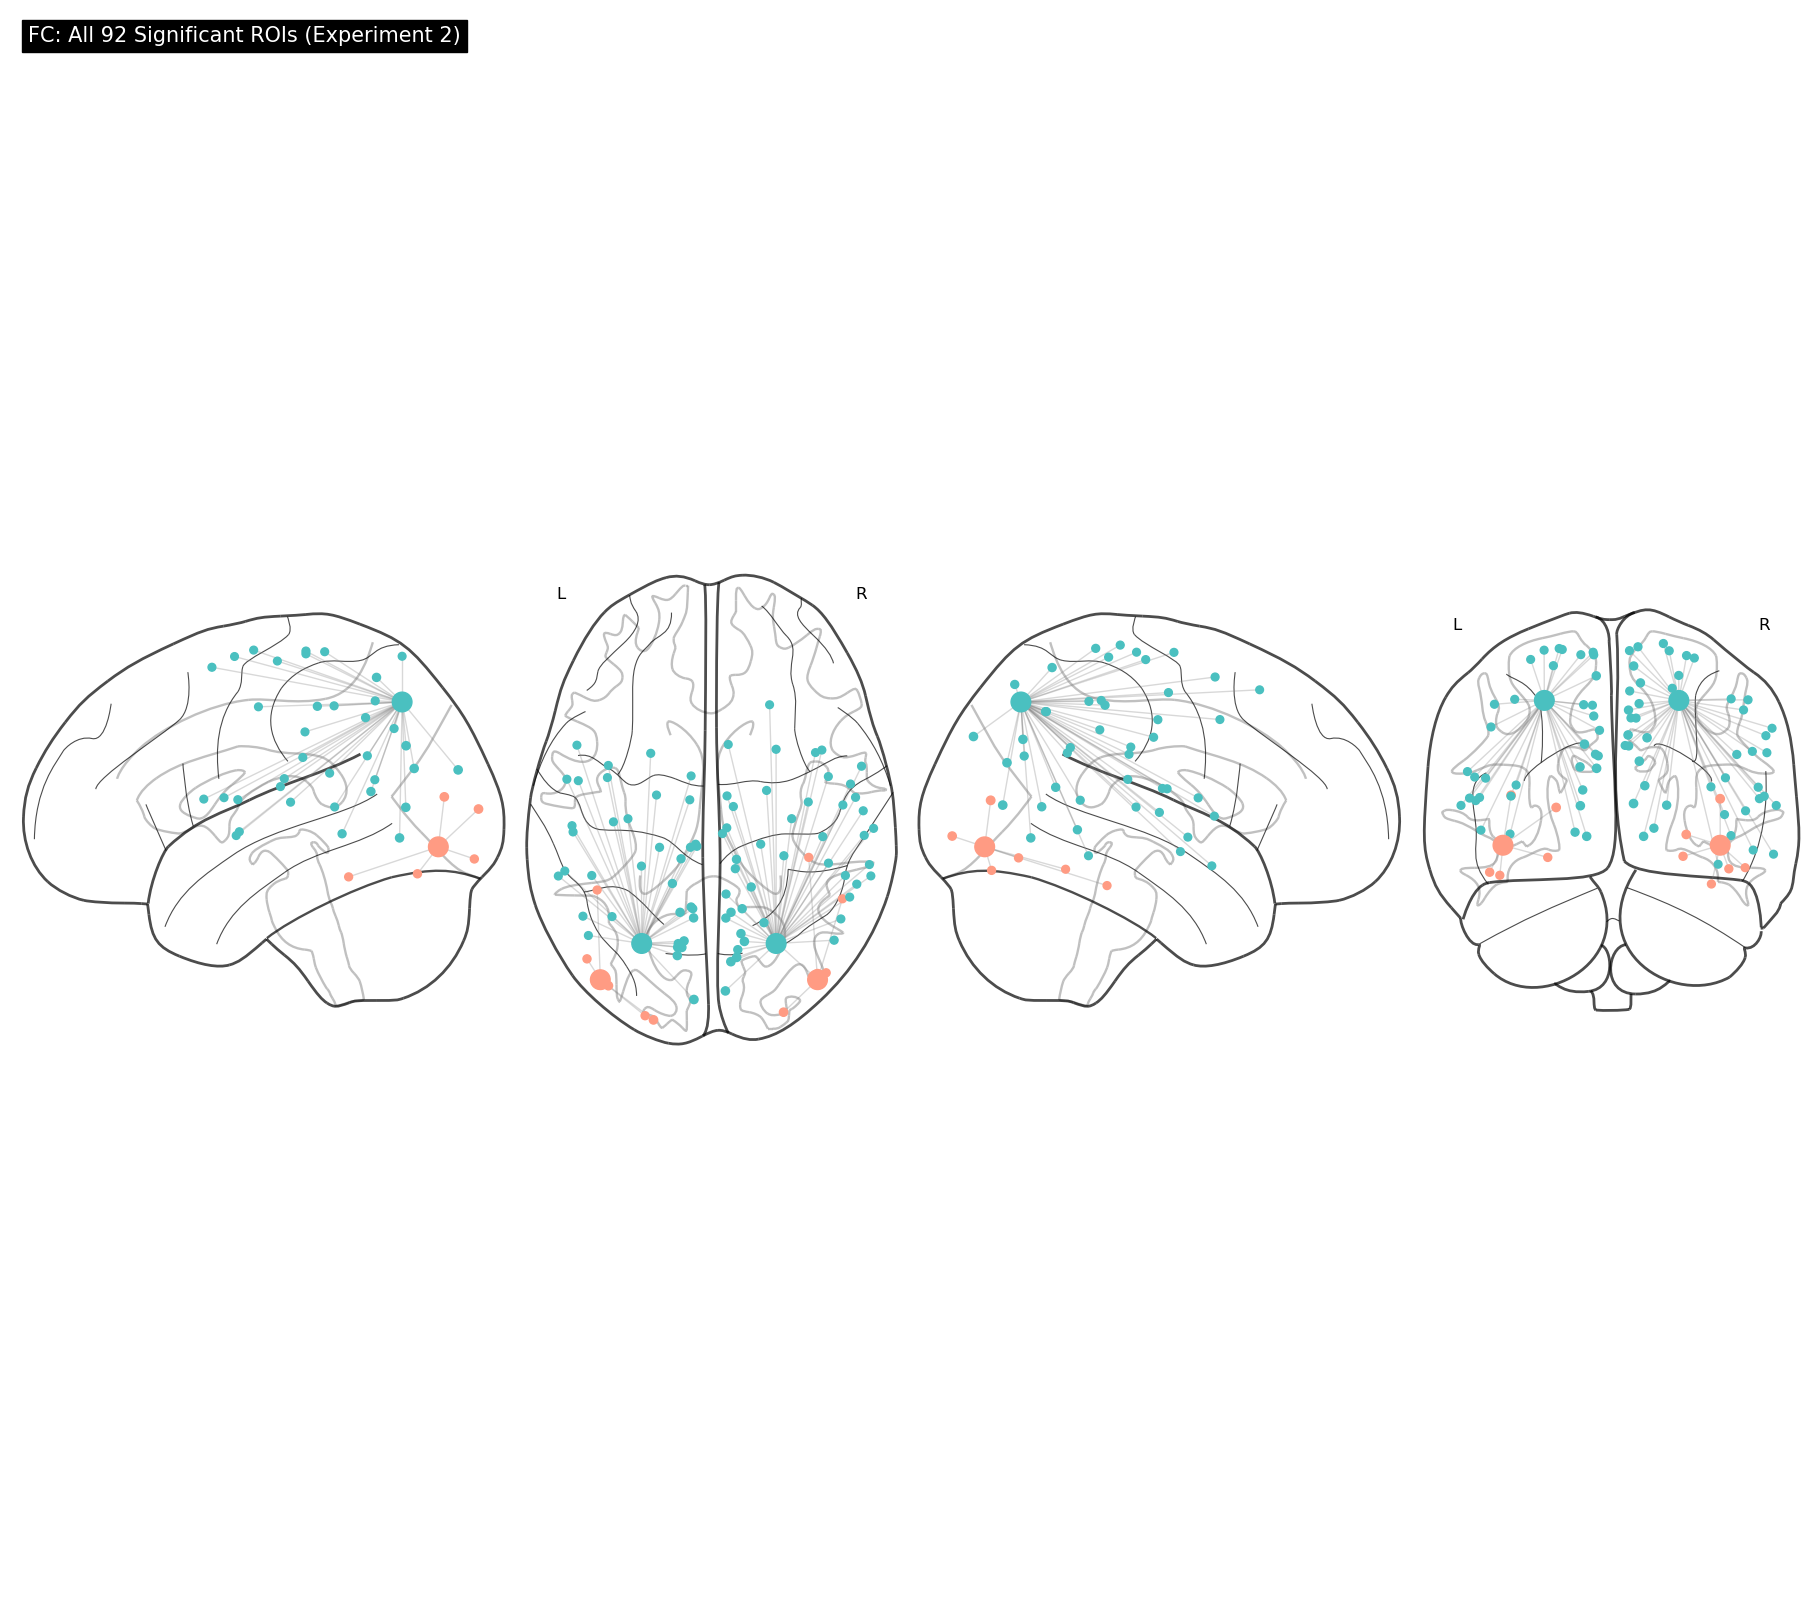

Brain network visualization complete for fc (Experiment 2)
Showing 92 significant ROIs connected to pIPS and LO seed regions
Figure saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/fc_brain_connectivity_exp2.png

CREATING PPI BRAIN CONNECTIVITY FIGURE FROM SAVED DATA (EXPERIMENT 2)
Loaded merged atlas with 202 regions
Loaded PPI data with 200 ROIs
Found 34 significant ROIs

Creating brain connectivity visualization for Experiment 2...


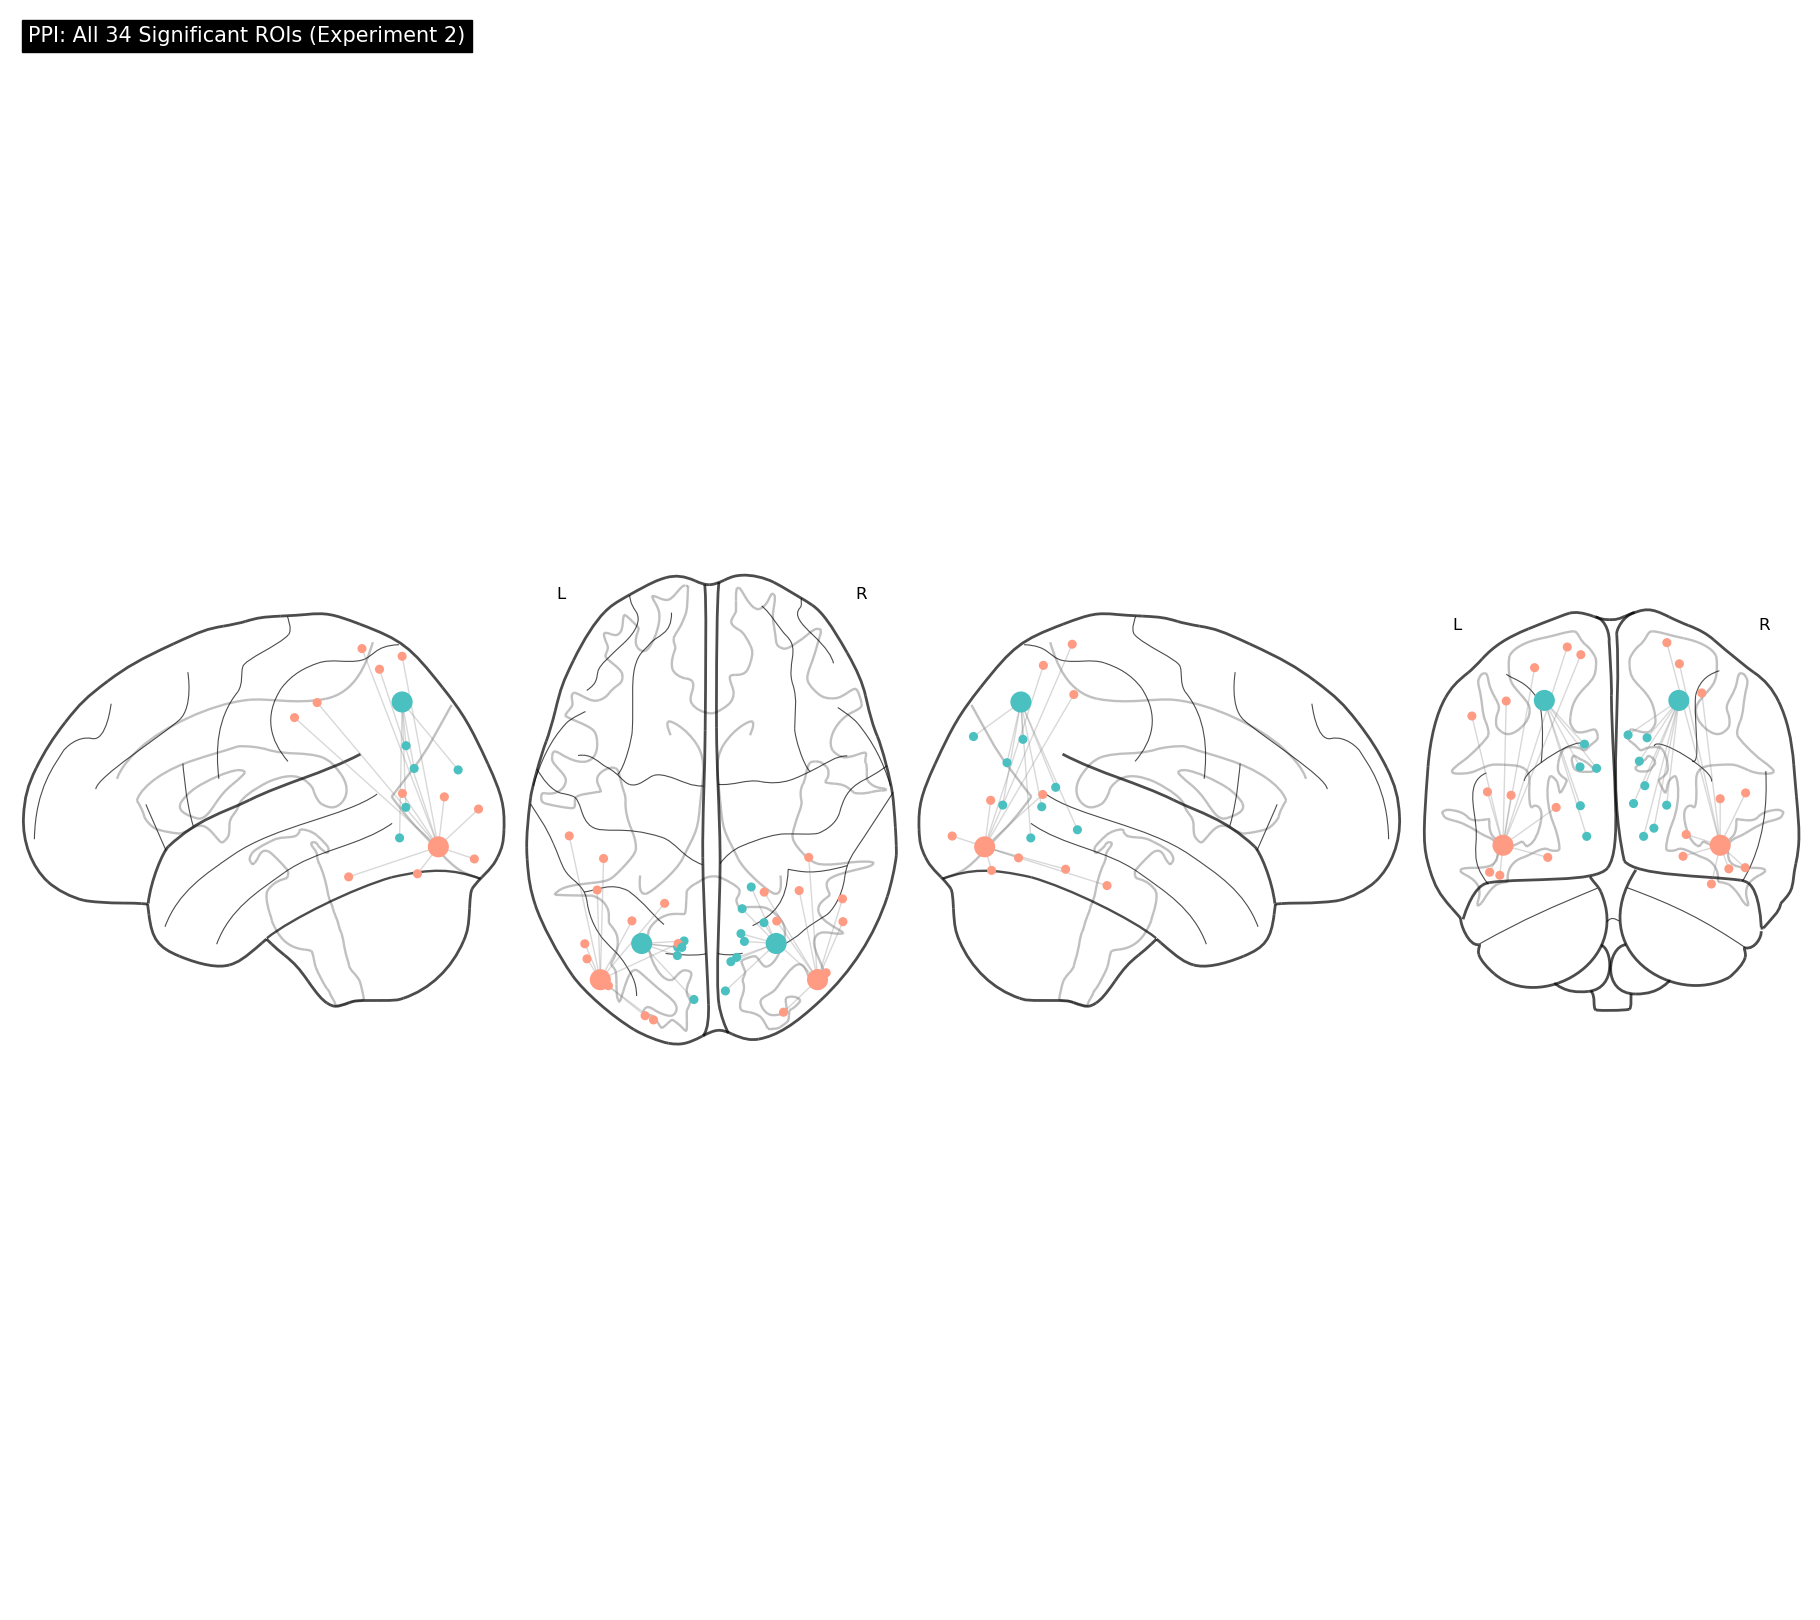

Brain network visualization complete for ppi (Experiment 2)
Showing 34 significant ROIs connected to pIPS and LO seed regions
Figure saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/ppi_brain_connectivity_exp2.png

Visualizations complete - figures were saved to disk.


In [15]:
# FC + PPI Brain Connectivity Figures for Experiment 2 using saved CSV data and merged atlas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nib

# Define paths - updated for experiment 2
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
connectivity_dir = f'{results_dir}/exp2_connectivity_comparison'  # Updated for exp 2

def visualize_brain_connectivity(analysis_type='fc'):
    """Create brain visualization for specified data type using saved CSV results - updated for Experiment 2"""
    print(f"\n{'='*80}")
    print(f"CREATING {analysis_type.upper()} BRAIN CONNECTIVITY FIGURE FROM SAVED DATA (EXPERIMENT 2)")
    print(f"{'='*80}")
    
    # Load merged atlas created for experiment 2
    merged_atlas_file = f'{results_dir}/exp2/schaefer_wang_merged_exp2.nii.gz'  # Updated for exp 2
    merged_labels_file = f'{results_dir}/exp2/merged_atlas_labels_exp2.npy'  # Updated for exp 2
    
    if not os.path.exists(merged_atlas_file) or not os.path.exists(merged_labels_file):
        print("Error: Merged atlas files for Experiment 2 not found. Please run merge_atlas_exp2.py first.")
        return None
    
    # Load merged atlas
    atlas_img = nib.load(merged_atlas_file)
    atlas_labels = np.load(merged_labels_file, allow_pickle=True)
    print(f"Loaded merged atlas with {len(atlas_labels)} regions")
    
    # Load saved connectivity results for experiment 2
    csv_path = f'{connectivity_dir}/bilateral_{analysis_type}_connectivity_fingerprint_results.csv'
    if not os.path.exists(csv_path):
        print(f"Error: Could not find {analysis_type.upper()} results at {csv_path}")
        return None
    
    # Load the data
    results_df = pd.read_csv(csv_path)
    print(f"Loaded {analysis_type.upper()} data with {len(results_df)} ROIs")
    
    # Filter to significant regions according to the combined criteria
    sig_df = results_df[results_df['Combined_Significant'] == True].copy()
    sig_df['Hemisphere'] = sig_df['ROI_Name'].apply(lambda x: 'L' if 'LH' in x else 'R' if 'RH' in x else 'X')
    
    print(f"Found {len(sig_df)} significant ROIs")
    
    # ==================================
    # BRAIN NETWORK VISUALIZATION
    # ==================================
    print("\nCreating brain connectivity visualization for Experiment 2...")
    
    if len(sig_df) > 0:
        # Get coordinates for all ROIs from the merged atlas
        all_coords = plotting.find_parcellation_cut_coords(atlas_img)
        
        # Prepare node properties for significant ROIs
        sig_coords = []
        sig_colors = []
        sig_sizes = []
        sig_labels = []
        
        for _, row in sig_df.iterrows():
            roi_idx = row['ROI_ID'] - 1  # Convert to 0-based index
            sig_coords.append(all_coords[roi_idx])
            sig_colors.append('#4ac0c0' if row['Difference'] > 0 else '#ff9b83')
            sig_sizes.append(abs(row['Difference']) * 40 + 30)
            sig_labels.append(f"{row['ROI_ID']}\n{row['ROI_Name'].split('_')[-1]}")
        
        # Add seed nodes
        seed_coords = [
            [-26, -68, 48], [26, -68, 48],  # pIPS L/R
            [-42, -82, -8], [42, -82, -8]    # LO L/R
        ]
        all_coords = sig_coords + seed_coords
        all_colors = sig_colors + ['#4ac0c0', '#4ac0c0', '#ff9b83', '#ff9b83']
        all_sizes = sig_sizes + [200, 200, 200, 200]
        
        # Create adjacency matrix
        adjacency = np.zeros((len(all_coords), len(all_coords)))
        for i, row in enumerate(sig_df.itertuples()):
            tgt_offset = 0 if row.Difference > 0 else 2
            tgt_idx = len(sig_coords) + tgt_offset + (0 if row.Hemisphere == 'L' else 1)
            adjacency[i, tgt_idx] = adjacency[tgt_idx, i] = 1
        
        # Create network plot
        fig = plt.figure(figsize=(18, 16))
        plotting.plot_connectome(
            adjacency, all_coords,
            node_color=all_colors,
            node_size=all_sizes,
            edge_kwargs={'color': 'gray', 'alpha': 0.3, 'linewidth': 1.0},
            display_mode='lzry',
            title=f'{analysis_type.upper()}: All {len(sig_df)} Significant ROIs (Experiment 2)',
            figure=fig
        )
        
        # Save the figure
        output_path = f'{connectivity_dir}/{analysis_type}_brain_connectivity_exp2.png'  # Updated filename for exp 2
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Brain network visualization complete for {analysis_type} (Experiment 2)")
        print(f"Showing {len(sig_df)} significant ROIs connected to pIPS and LO seed regions")
        print(f"Figure saved to {output_path}")
    else:
        print(f"No significant ROIs found for {analysis_type}. Cannot create brain visualization.")
    
    return sig_df

# Run visualizations for both FC and PPI for Experiment 2
print("\nCreating brain connectivity visualizations from saved CSV data for Experiment 2...")
fc_results = visualize_brain_connectivity(analysis_type='fc')
ppi_results = visualize_brain_connectivity(analysis_type='ppi')

print("\nVisualizations complete - figures were saved to disk.")


Creating brain connectivity visualizations from saved CSV data for Experiment 2...
Loaded merged atlas labels with 202 regions for Experiment 2
Loaded FC results from /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/bilateral_fc_connectivity_fingerprint_results.csv

CREATING FC ANATOMICAL ORGANIZATION VISUALIZATION FOR EXPERIMENT 2


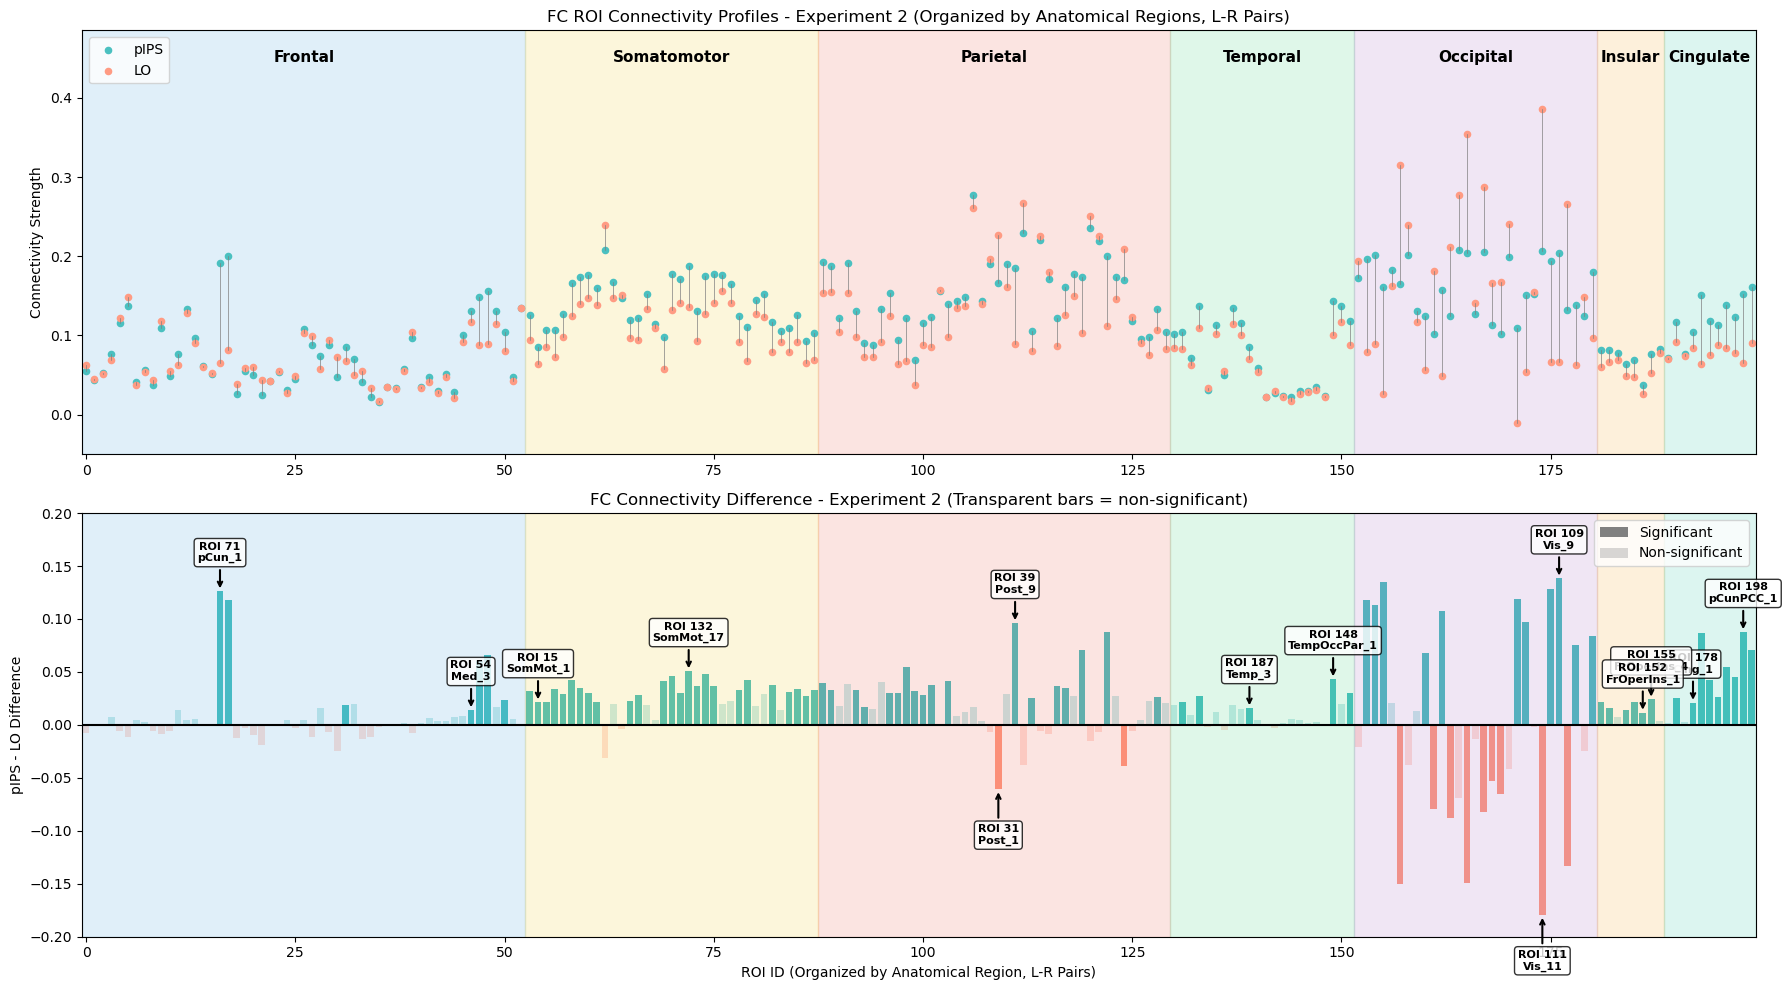

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/fc_anatomical_organization_exp2.png

FC significant peak and bottom ROIs by anatomical lobe (Experiment 2):

Cingulate Lobe:
  Peak (pIPS > LO): ROI 198 (pCunPCC_1), Diff = 0.088
  Bottom (LO > pIPS): ROI 178 (Cing_1), Diff = 0.021

Frontal Lobe:
  Peak (pIPS > LO): ROI 71 (pCun_1), Diff = 0.126
  Bottom (LO > pIPS): ROI 54 (Med_3), Diff = 0.014

Insular Lobe:
  Peak (pIPS > LO): ROI 155 (FrOperIns_4), Diff = 0.024
  Bottom (LO > pIPS): ROI 152 (FrOperIns_1), Diff = 0.012

Occipital Lobe:
  Peak (pIPS > LO): ROI 109 (Vis_9), Diff = 0.138
  Bottom (LO > pIPS): ROI 111 (Vis_11), Diff = -0.179

Parietal Lobe:
  Peak (pIPS > LO): ROI 39 (Post_9), Diff = 0.096
  Bottom (LO > pIPS): ROI 31 (Post_1), Diff = -0.061

Somatomotor Lobe:
  Peak (pIPS > LO): ROI 132 (SomMot_17), Diff = 0.051
  Bottom (LO > pIPS): ROI 15 (SomMot_1), Diff = 0.021

Temporal Lobe:
  Peak (pIPS > LO): ROI 148 (TempOccPar_1), Diff = 0

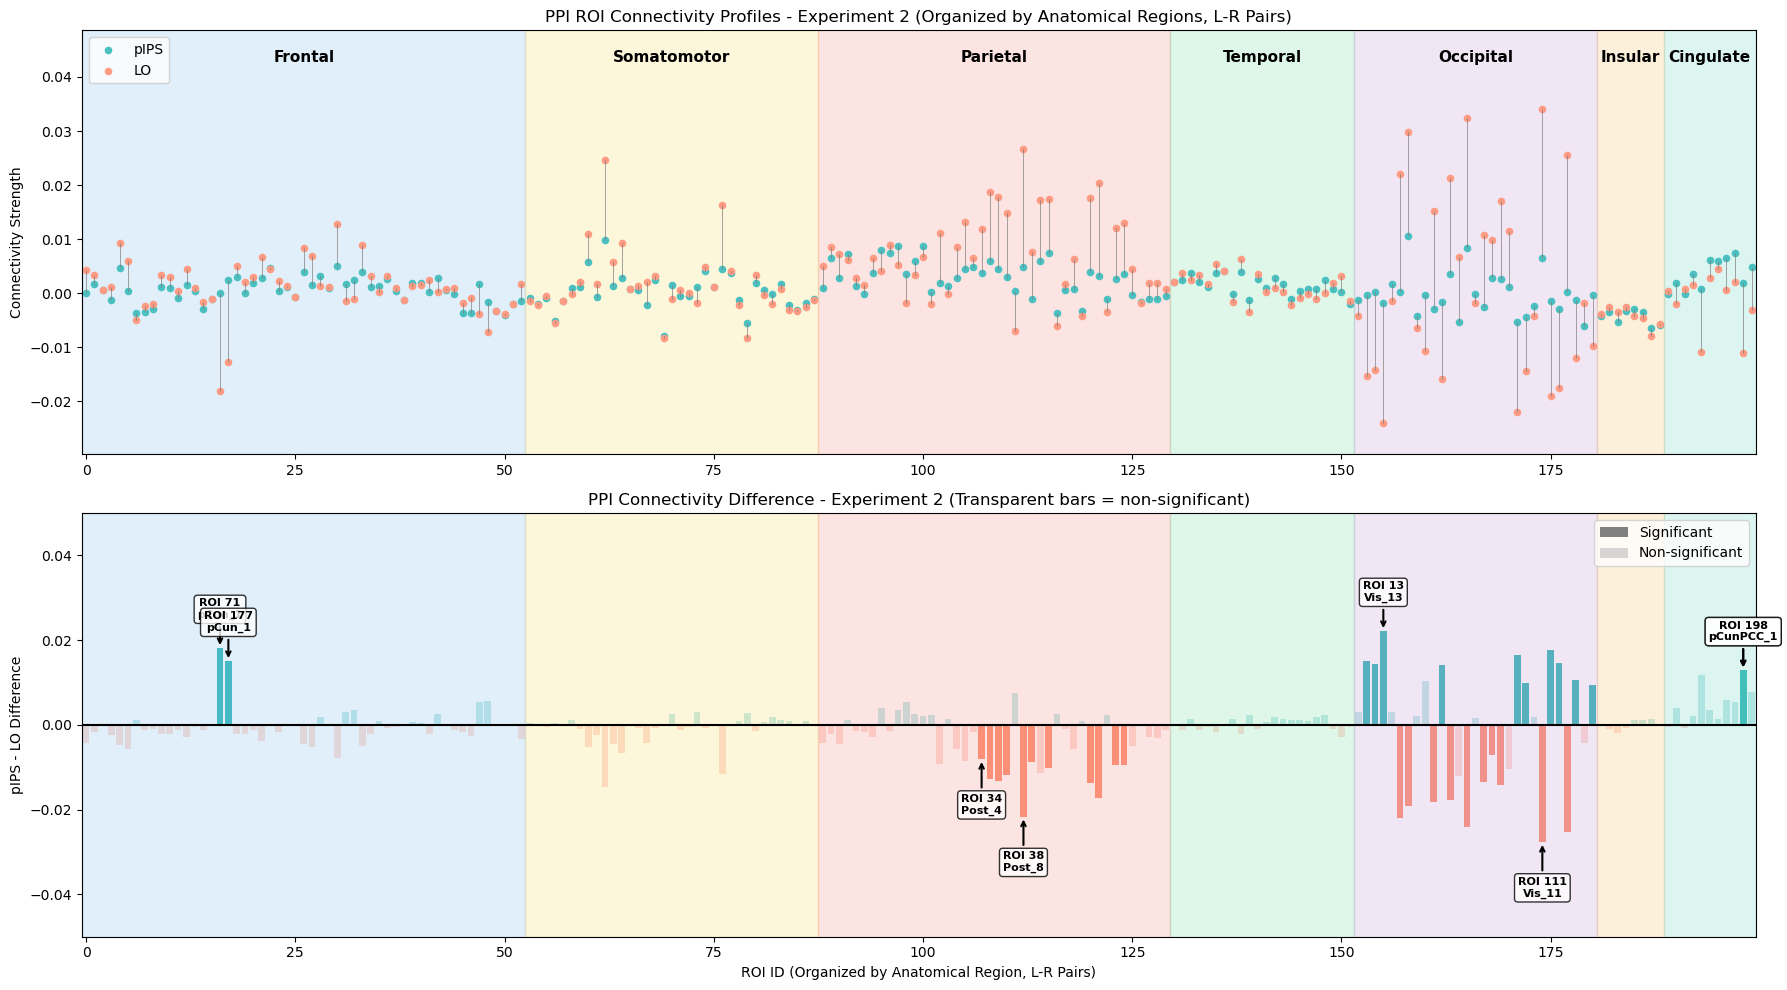

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/ppi_anatomical_organization_exp2.png

PPI significant peak and bottom ROIs by anatomical lobe (Experiment 2):

Cingulate Lobe:
  Peak (pIPS > LO): ROI 198 (pCunPCC_1), Diff = 0.013
  Bottom (LO > pIPS): ROI 198 (pCunPCC_1), Diff = 0.013

Frontal Lobe:
  Peak (pIPS > LO): ROI 71 (pCun_1), Diff = 0.018
  Bottom (LO > pIPS): ROI 177 (pCun_1), Diff = 0.015

Occipital Lobe:
  Peak (pIPS > LO): ROI 13 (Vis_13), Diff = 0.022
  Bottom (LO > pIPS): ROI 111 (Vis_11), Diff = -0.028

Parietal Lobe:
  Peak (pIPS > LO): ROI 34 (Post_4), Diff = -0.008
  Bottom (LO > pIPS): ROI 38 (Post_8), Diff = -0.022


In [16]:
# Regional Brain Connectivity Analysis Part 2: Visualization for Experiment 2
# Description: Visualization of functional connectivity (FC) and psychophysiological interaction (PPI)
#              between parietal IPS and lateral occipital regions organized by anatomical location
#              Updated for Experiment 2 with tool localizer data

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from matplotlib.patches import Patch

# Define paths - updated for experiment 2
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
output_dir = f'{results_dir}/exp2_connectivity_comparison'  # Updated for exp 2

def visualize_anatomical_organization(results_df, roi_data, analysis_type='fc'):
    """Create anatomical organization visualization - updated for Experiment 2"""
    print(f"\n{'='*80}")
    print(f"CREATING {analysis_type.upper()} ANATOMICAL ORGANIZATION VISUALIZATION FOR EXPERIMENT 2")
    print(f"{'='*80}")
    
    # Extract data from parameters
    mean_pips = roi_data['mean_pips']
    mean_lo = roi_data['mean_lo']
    diff_profile = roi_data['diff_profile']
    ci_lower = roi_data['ci_lower']
    ci_upper = roi_data['ci_upper']
    sig_combined = roi_data['sig_combined']
    
    # Function to map ROI names to anatomical lobes
    def map_to_anatomical_lobe(roi_name):
        # Special handling for Wang atlas ROIs
        if 'Wang_pIPS' in roi_name:
            return 'Parietal'
        elif 'Wang_LO' in roi_name:
            return 'Temporal'
        
        # Map Schaefer networks to anatomical regions
        if 'Vis' in roi_name:
            return 'Occipital'
        elif 'SomMot' in roi_name:
            return 'Somatomotor'
        elif 'DorsAttn' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            else:
                return 'Parietal'
        elif 'SalVentAttn' in roi_name:
            if 'Ins' in roi_name:
                return 'Insular'
            elif 'Cing' in roi_name or 'ACC' in roi_name:
                return 'Cingulate'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'Par' in roi_name:
                return 'Parietal'
            else:
                return 'Frontal'
        elif 'Limbic' in roi_name:
            if 'Temp' in roi_name:
                return 'Temporal'
            else:
                return 'Frontal'
        elif 'Cont' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            elif 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        elif 'Default' in roi_name:
            if 'Par' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'PCC' in roi_name or 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        else:
            return 'Other'
    
    # Clean up ROI names for better labeling
    def clean_roi_name(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Handle Wang ROIs
        if 'Wang_' in roi_name:
            return roi_name.replace('Wang_', '')
        
        # Remove common prefixes and suffixes
        cleaned = roi_name.replace('7Networks_', '')
        
        # Extract just the region part, removing hemisphere and network
        parts = cleaned.split('_')
        if len(parts) > 2:
            return parts[-2] + '_' + parts[-1]
        elif len(parts) > 1:
            return parts[-1]
        else:
            return cleaned
    
    # Determine hemisphere and base region for organizing pairs
    def get_hemisphere_and_region(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Determine hemisphere 
        if 'LH' in roi_name:
            hemisphere = 'L'
        elif 'RH' in roi_name:
            hemisphere = 'R'
        else:
            # For Wang ROIs or ROIs without clear hemisphere
            if 'Wang_pIPS' in roi_name or 'Wang_LO' in roi_name:
                hemisphere = 'X'  # Bilateral
            else:
                hemisphere = 'X'  # Unknown
        
        # Extract base region by removing hemisphere and number
        cleaned = roi_name.replace('7Networks_', '')
        cleaned = cleaned.replace('LH_', '').replace('RH_', '')
        
        # Handle Wang ROIs
        if 'Wang_' in cleaned:
            base_region = cleaned.replace('Wang_', '')
        else:
            # Remove trailing numbers which often differentiate regions
            base_region = re.sub(r'_\d+$', '', cleaned)
        
        return hemisphere, base_region
    
    # Add anatomical lobe and hemisphere information to the dataframe
    results_df['Anatomical_Lobe'] = results_df['ROI_Name'].apply(map_to_anatomical_lobe)
    results_df['Clean_Name'] = results_df['ROI_Name'].apply(clean_roi_name)
    
    # Extract hemisphere and base region info
    hemisphere_region = results_df['ROI_Name'].apply(get_hemisphere_and_region)
    results_df['Hemisphere'] = [h for h, r in hemisphere_region]
    results_df['Base_Region'] = [r for h, r in hemisphere_region]
    
    # Define a manual order for anatomical lobes
    lobe_order = [
        'Frontal',
        'Somatomotor',
        'Parietal',
        'Temporal',
        'Occipital',
        'Insular',
        'Cingulate',
        'Other'
    ]
    
    # Create a category for sorting based on the defined order
    lobe_cat = pd.Categorical(results_df['Anatomical_Lobe'], categories=lobe_order, ordered=True)
    results_df['Lobe_Sorted'] = lobe_cat
    
    # Define a consistent color palette for brain lobes
    lobe_colors = {
        'Frontal': '#3498db',     # Blue
        'Somatomotor': '#f1c40f', # Yellow
        'Parietal': '#e74c3c',    # Red
        'Temporal': '#2ecc71',    # Green
        'Occipital': '#9b59b6',   # Purple
        'Insular': '#f39c12',     # Orange
        'Cingulate': '#1abc9c',   # Turquoise
        'Other': '#7f8c8d'        # Gray
    }
    
    # Custom sorting function to group by lobe, then by base region, then by hemisphere (L then R)
    def custom_sort(row):
        lobe_idx = lobe_order.index(row['Anatomical_Lobe']) if row['Anatomical_Lobe'] in lobe_order else 999
        hemi_idx = 0 if row['Hemisphere'] == 'L' else 1 if row['Hemisphere'] == 'R' else 2
        return (lobe_idx, row['Base_Region'], hemi_idx)
    
    # Sort using the custom function
    results_df['sort_key'] = results_df.apply(custom_sort, axis=1)
    results_df_sorted = results_df.sort_values('sort_key')
    
    # Get the new order
    sorted_indices = results_df_sorted.index.values
    
    # Extract reordered data
    mean_pips_sorted = results_df_sorted['pIPS_Connectivity'].values
    mean_lo_sorted = results_df_sorted['LO_Connectivity'].values
    diff_profile_sorted = results_df_sorted['Difference'].values
    sig_sorted = results_df_sorted['Combined_Significant'].values
    
    # Find peak (highest) and bottom (lowest) significant ROI in each lobe
    significant_peak_bottom_indices = []
    lobe_groups = results_df_sorted.groupby('Anatomical_Lobe')
    
    for lobe, group in lobe_groups:
        if len(group) > 0:
            # Get significant ROIs in this lobe
            sig_group = group[group['Combined_Significant']]
            
            if len(sig_group) > 0:
                # Get highest difference (most pIPS-preferring) significant ROI
                peak_idx = sig_group['Difference'].idxmax()
                significant_peak_bottom_indices.append(peak_idx)
                
                # Get lowest difference (most LO-preferring) significant ROI
                bottom_idx = sig_group['Difference'].idxmin()
                significant_peak_bottom_indices.append(bottom_idx)
    
    # Create the visualization
    plt.figure(figsize=(18, 10))
    
    # Top subplot - connectivity profiles with lollipop plot, organized by lobe
    ax1 = plt.subplot(2, 1, 1)
    x = np.arange(len(mean_pips_sorted))
    
    # Get the y-limits for label positioning
    y_min, y_max = min(min(mean_pips_sorted), min(mean_lo_sorted)), max(max(mean_pips_sorted), max(mean_lo_sorted))
    y_range = y_max - y_min
    
    # Plot background colors for different lobes
    current_lobe = None
    start_idx = 0
    
    for i, idx in enumerate(sorted_indices):
        lobe = results_df_sorted.iloc[i]['Anatomical_Lobe']
        if lobe != current_lobe:
            if current_lobe is not None:
                # Mark the region for the previous lobe
                plt.axvspan(start_idx - 0.5, i - 0.5, alpha=0.15, 
                           color=lobe_colors[current_lobe])
                # Add label in the middle of the region with fixed top position
                label_y = y_max + 0.15 * y_range  # Position labels above the data
                plt.text((start_idx + i - 1) / 2, label_y, 
                        current_lobe, ha='center', fontsize=11, fontweight='bold')
            current_lobe = lobe
            start_idx = i
    
    # Add the last region
    plt.axvspan(start_idx - 0.5, len(mean_pips_sorted) - 0.5, alpha=0.15, 
               color=lobe_colors[current_lobe])
    plt.text((start_idx + len(mean_pips_sorted) - 1) / 2, y_max + 0.15 * y_range, 
            current_lobe, ha='center', fontsize=11, fontweight='bold')
    
    # Create lollipop plot - vertical lines connecting pIPS and LO points
    for i in range(len(x)):
        plt.plot([x[i], x[i]], [mean_pips_sorted[i], mean_lo_sorted[i]], color='gray', linestyle='-', linewidth=0.5)
    
    # Plot the points
    plt.scatter(x, mean_pips_sorted, color='#4ac0c0', s=20, label='pIPS')
    plt.scatter(x, mean_lo_sorted, color='#ff9b83', s=20, label='LO')
    
    # Set y-axis limits with padding for the labels
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.25 * y_range)
    
    plt.ylabel('Connectivity Strength')
    plt.title(f'{analysis_type.upper()} ROI Connectivity Profiles - Experiment 2 (Organized by Anatomical Regions, L-R Pairs)')
    plt.legend(loc='upper left')
    plt.xlim(-0.5, len(mean_pips_sorted) - 0.5)
    
    # Bottom subplot - difference
    ax2 = plt.subplot(2, 1, 2)
    
    # Create base bar plot for all bars
    base_colors = ['#4ac0c0' if val > 0 else '#ff9b83' for val in diff_profile_sorted]
    bars = plt.bar(x, diff_profile_sorted, color=base_colors)
    
    # Apply transparency to non-significant bars individually
    for i, (bar, is_sig) in enumerate(zip(bars, sig_sorted)):
        if not is_sig:
            # Set alpha for non-significant bars only
            bar.set_alpha(0.3)
    
    plt.axhline(y=0, color='black', linestyle='-')
    
    # Add a legend for significance
    legend_elements = [
        Patch(facecolor='gray', alpha=1.0, label='Significant'),
        Patch(facecolor='gray', alpha=0.3, label='Non-significant')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Add background colors for different lobes (same as top plot)
    current_lobe = None
    start_idx = 0
    
    for i, idx in enumerate(sorted_indices):
        lobe = results_df_sorted.iloc[i]['Anatomical_Lobe']
        if lobe != current_lobe:
            if current_lobe is not None:
                plt.axvspan(start_idx - 0.5, i - 0.5, alpha=0.15, 
                           color=lobe_colors[current_lobe])
            current_lobe = lobe
            start_idx = i
    
    # Add the last region
    plt.axvspan(start_idx - 0.5, len(mean_pips_sorted) - 0.5, alpha=0.15, 
               color=lobe_colors[current_lobe])
    
    # Label only significant peak and bottom ROIs
    for peak_idx in significant_peak_bottom_indices:
        # Find position in sorted array
        position = np.where(sorted_indices == peak_idx)[0][0]
        roi_id = results_df.loc[peak_idx, 'ROI_ID']
        roi_name = results_df.loc[peak_idx, 'Clean_Name']
        diff_value = results_df.loc[peak_idx, 'Difference']
        
        # Add annotation for ROI
        plt.annotate(f'ROI {roi_id}\n{roi_name}',
                    xy=(position, diff_value),
                    xytext=(0, 20 if diff_value >= 0 else -25),
                    textcoords='offset points',
                    ha='center',
                    va='bottom' if diff_value >= 0 else 'top',
                    fontsize=8,
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', lw=1.5))
    
    plt.ylabel('pIPS - LO Difference')
    plt.xlabel('ROI ID (Organized by Anatomical Region, L-R Pairs)')
    plt.title(f'{analysis_type.upper()} Connectivity Difference - Experiment 2 (Transparent bars = non-significant)')
    plt.xlim(-0.5, len(mean_pips_sorted) - 0.5)
    
    # Set different y-axis limits for the second panel based on analysis type
    if analysis_type == 'fc':
        # For FC analysis: range from -0.2 to 0.2
        plt.ylim(-0.2, 0.2)
    else:  # For PPI analysis
        # For PPI analysis: range from -0.05 to 0.05
        plt.ylim(-0.05, 0.05)
    
    plt.tight_layout()
    
    # Save the figure
    fig_path = f'{output_dir}/{analysis_type}_anatomical_organization_exp2.png'  # Updated for exp 2
    plt.savefig(fig_path, dpi=300)
    plt.show()
    
    print(f"Figure saved to {fig_path}")
    
    # Print peak and bottom ROIs by lobe, only for significant ROIs
    print(f"\n{analysis_type.upper()} significant peak and bottom ROIs by anatomical lobe (Experiment 2):")
    for lobe, group in lobe_groups:
        # Get significant ROIs in this lobe
        sig_group = group[group['Combined_Significant']]
        
        if len(sig_group) > 0:
            print(f"\n{lobe} Lobe:")
            
            # Peak (pIPS-preferring) significant ROI
            peak_row = sig_group.loc[sig_group['Difference'].idxmax()]
            print(f"  Peak (pIPS > LO): ROI {peak_row['ROI_ID']} ({peak_row['Clean_Name']}), " + 
                  f"Diff = {peak_row['Difference']:.3f}")
            
            # Bottom (LO-preferring) significant ROI
            bottom_row = sig_group.loc[sig_group['Difference'].idxmin()]
            print(f"  Bottom (LO > pIPS): ROI {bottom_row['ROI_ID']} ({bottom_row['Clean_Name']}), " + 
                  f"Diff = {bottom_row['Difference']:.3f}")
    
    return

# Load saved results and create visualizations for Experiment 2
def load_and_visualize_results():
    # Check if merged atlas exists for Experiment 2
    merged_atlas_file = f'{results_dir}/exp2/schaefer_wang_merged_exp2.nii.gz'  # Updated for exp 2
    merged_labels_file = f'{results_dir}/exp2/merged_atlas_labels_exp2.npy'  # Updated for exp 2
    
    if not os.path.exists(merged_atlas_file) or not os.path.exists(merged_labels_file):
        print("Error: Merged atlas files for Experiment 2 not found. Please run merge_atlas_exp2.py first.")
        return
    
    # Load merged atlas labels
    atlas_labels = np.load(merged_labels_file, allow_pickle=True)
    print(f"Loaded merged atlas labels with {len(atlas_labels)} regions for Experiment 2")
    
    # Load FC results for Experiment 2
    fc_csv_path = f'{output_dir}/bilateral_fc_connectivity_fingerprint_results.csv'
    if os.path.exists(fc_csv_path):
        fc_results = pd.read_csv(fc_csv_path)
        print(f"Loaded FC results from {fc_csv_path}")
        
        # Extract data needed for visualization
        fc_data = {
            'mean_pips': fc_results['pIPS_Connectivity'].values,
            'mean_lo': fc_results['LO_Connectivity'].values,
            'diff_profile': fc_results['Difference'].values,
            'ci_lower': fc_results['CI_Lower'].values,
            'ci_upper': fc_results['CI_Upper'].values,
            'sig_combined': fc_results['Combined_Significant'].values
        }
        
        # Create FC visualization
        visualize_anatomical_organization(fc_results, fc_data, analysis_type='fc')
    else:
        print(f"FC results file not found: {fc_csv_path}")
    
    # Load PPI results for Experiment 2
    ppi_csv_path = f'{output_dir}/bilateral_ppi_connectivity_fingerprint_results.csv'
    if os.path.exists(ppi_csv_path):
        ppi_results = pd.read_csv(ppi_csv_path)
        print(f"Loaded PPI results from {ppi_csv_path}")
        
        # Extract data needed for visualization
        ppi_data = {
            'mean_pips': ppi_results['pIPS_Connectivity'].values,
            'mean_lo': ppi_results['LO_Connectivity'].values,
            'diff_profile': ppi_results['Difference'].values,
            'ci_lower': ppi_results['CI_Lower'].values,
            'ci_upper': ppi_results['CI_Upper'].values,
            'sig_combined': ppi_results['Combined_Significant'].values
        }
        
        # Create PPI visualization
        visualize_anatomical_organization(ppi_results, ppi_data, analysis_type='ppi')
    else:
        print(f"PPI results file not found: {ppi_csv_path}")

# Run visualizations for Experiment 2
print("\nCreating brain connectivity visualizations from saved CSV data for Experiment 2...")
load_and_visualize_results()


Running connectivity asymmetry analysis for Experiment 2...

ANALYZING FC ASYMMETRY IN CONNECTIONS BETWEEN pIPS AND LO FOR EXPERIMENT 2...
Merged atlas files for Experiment 2 found. Analysis will use results from merged atlas approach.
Loaded FC connectivity data with 200 ROIs
Found 92 significant ROIs
pIPS > LO: 81 regions
LO > pIPS: 11 regions

Chi-square test for asymmetry in number of connections:
Observed frequencies: pIPS > LO: 81, LO > pIPS: 11
Expected frequencies: pIPS > LO: 46.0, LO > pIPS: 46.0
Chi-square statistic: 53.2609
p-value: 0.00000000
The asymmetry in number of connections is statistically significant.
pIPS has significantly more connections than LO (p < .001).

Mean strength of pIPS-dominant connections: 0.0484 ± 0.0329
Mean strength of LO-dominant connections: 0.0982 ± 0.0447

Mann-Whitney U test for connection strength differences:
U statistic: 142.0
p-value: 0.00026604
LO-dominant connections are significantly stronger than pIPS-dominant connections (p < .001).

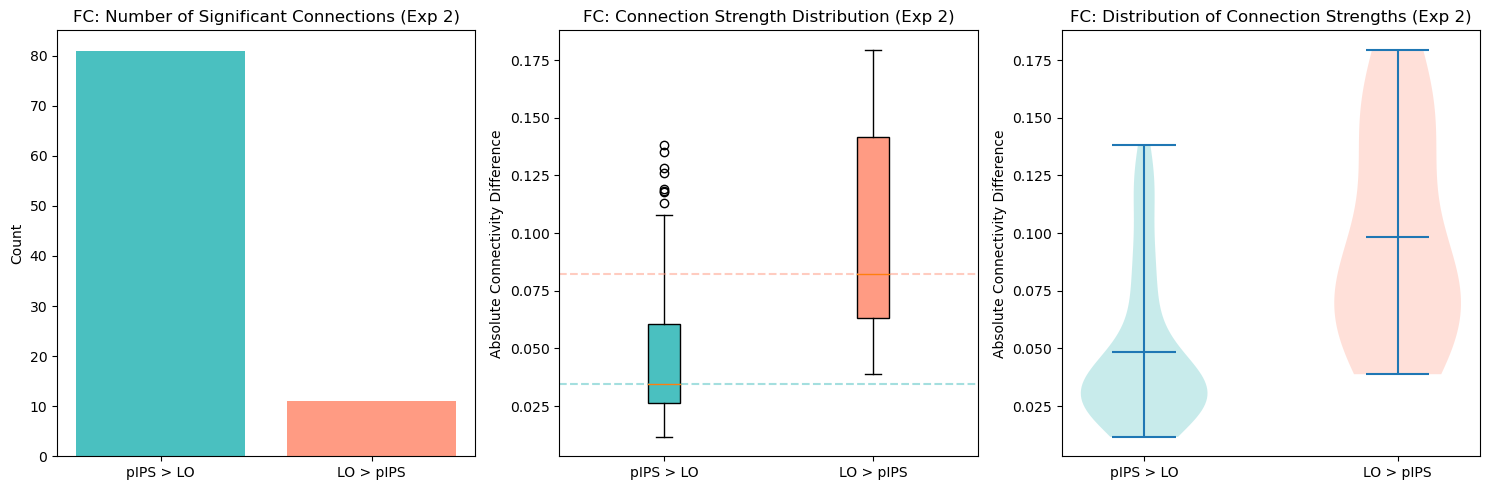


FC analysis complete. Results saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_asymmetry

ANALYZING PPI ASYMMETRY IN CONNECTIONS BETWEEN pIPS AND LO FOR EXPERIMENT 2...
Merged atlas files for Experiment 2 found. Analysis will use results from merged atlas approach.
Loaded PPI connectivity data with 200 ROIs
Found 34 significant ROIs
pIPS > LO: 13 regions
LO > pIPS: 21 regions

Chi-square test for asymmetry in number of connections:
Observed frequencies: pIPS > LO: 13, LO > pIPS: 21
Expected frequencies: pIPS > LO: 17.0, LO > pIPS: 17.0
Chi-square statistic: 1.8824
p-value: 0.17006696
The asymmetry in number of connections is not statistically significant.

Mean strength of pIPS-dominant connections: 0.0147 ± 0.0034
Mean strength of LO-dominant connections: 0.0155 ± 0.0059

Mann-Whitney U test for connection strength differences:
U statistic: 138.0
p-value: 0.97173009
No significant difference in connection strength between pIPS-dominant and LO-dominant regions.

T

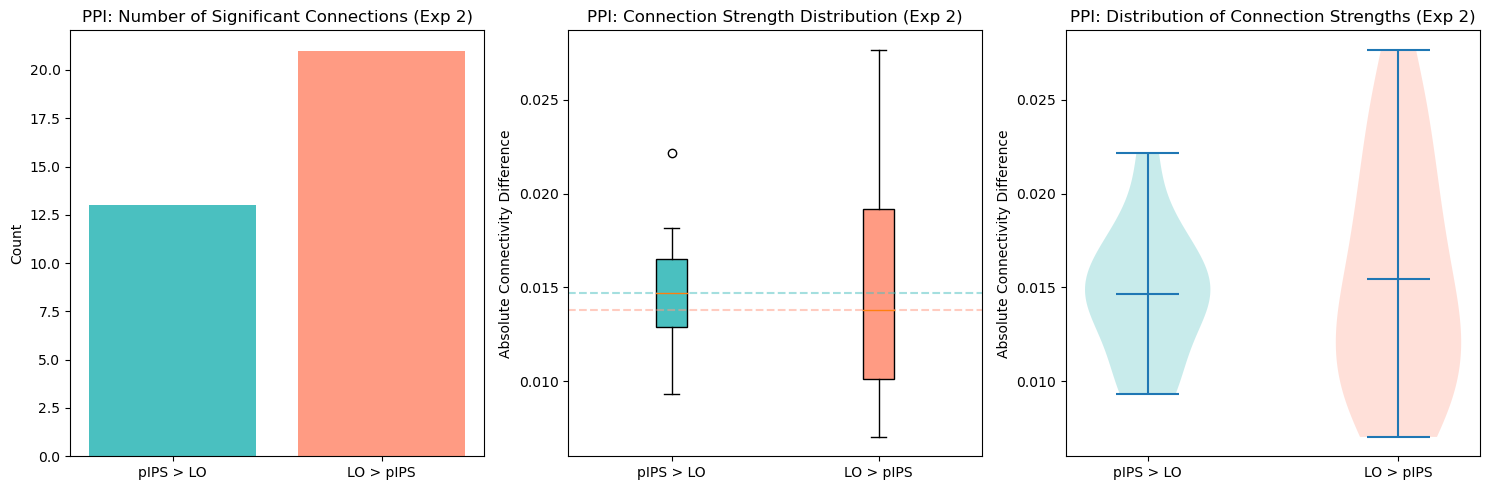


PPI analysis complete. Results saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_asymmetry

COMPARISON SUMMARY: FC vs PPI ASYMMETRY ANALYSIS FOR EXPERIMENT 2

Number of significant connections:
FC: pIPS > LO: 81, LO > pIPS: 11
PPI: pIPS > LO: 13, LO > pIPS: 21

Asymmetry significance:
FC: Chi-square = 53.2609, p = 0.00000000
PPI: Chi-square = 1.8824, p = 0.17006696

Connection strength metrics:
FC:
  pIPS mean: 0.0484, median: 0.0344
  LO mean: 0.0982, median: 0.0821
  Ratio pIPS/LO total: 3.63
PPI:
  pIPS mean: 0.0147, median: 0.0147
  LO mean: 0.0155, median: 0.0138
  Ratio pIPS/LO total: 0.59


In [17]:
# Chi-squared test for independence in Experiment 2
# Chi-square comparison of pIPS>LO connectivities for both FC and PPI in the tool localizer experiment
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

def analyze_connectivity_asymmetry(analysis_type='fc'):
    """
    Analyze the asymmetry in number and strength of connections for pIPS and LO regions.
    Tests whether pIPS has significantly more and stronger connections than LO.
    Uses Mann-Whitney U test for strength comparison to handle unequal sample sizes.
    Updated for Experiment 2 with tool localizer data.
    
    Parameters:
    -----------
    analysis_type : str
        Type of analysis to perform, either 'fc' or 'ppi'
    """
    # Define paths - updated for experiment 2
    results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
    connectivity_dir = f'{results_dir}/exp2_connectivity_comparison'  # Updated for exp 2
    output_dir = f'{results_dir}/exp2_connectivity_asymmetry'  # Updated for exp 2
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"\n{'='*80}")
    print(f"ANALYZING {analysis_type.upper()} ASYMMETRY IN CONNECTIONS BETWEEN pIPS AND LO FOR EXPERIMENT 2...")
    print(f"{'='*80}")
    
    # Check if merged atlas exists for Experiment 2
    merged_atlas_file = f'{results_dir}/exp2/schaefer_wang_merged_exp2.nii.gz'  # Updated for exp 2
    merged_labels_file = f'{results_dir}/exp2/merged_atlas_labels_exp2.npy'  # Updated for exp 2
    
    if not os.path.exists(merged_atlas_file) or not os.path.exists(merged_labels_file):
        print("Warning: Merged atlas files for Experiment 2 not found. Results may not reflect merged atlas.")
    else:
        print("Merged atlas files for Experiment 2 found. Analysis will use results from merged atlas approach.")
    
    # Load connectivity results from CSV
    results_path = f'{connectivity_dir}/bilateral_{analysis_type}_connectivity_fingerprint_results.csv'
    if not os.path.exists(results_path):
        print(f"Error: Could not find {analysis_type.upper()} connectivity results at {results_path}")
        return None
    
    results_df = pd.read_csv(results_path)
    print(f"Loaded {analysis_type.upper()} connectivity data with {len(results_df)} ROIs")
    
    # Filter to significant regions according to the combined criteria
    sig_regions = results_df[results_df['Combined_Significant'] == True]
    print(f"Found {len(sig_regions)} significant ROIs")
    
    # Count regions by direction
    pips_stronger_count = sum(sig_regions['Direction'] == 'pIPS > LO')
    lo_stronger_count = sum(sig_regions['Direction'] == 'LO > pIPS')
    
    print(f"pIPS > LO: {pips_stronger_count} regions")
    print(f"LO > pIPS: {lo_stronger_count} regions")
    
    # 1. Chi-square test for number of connections
    observed = np.array([pips_stronger_count, lo_stronger_count])
    expected = np.array([observed.sum()/2, observed.sum()/2])  # Expected under null hypothesis of equal distribution
    
    chi2, p_value = stats.chisquare(observed, expected)
    
    print("\nChi-square test for asymmetry in number of connections:")
    print(f"Observed frequencies: pIPS > LO: {observed[0]}, LO > pIPS: {observed[1]}")
    print(f"Expected frequencies: pIPS > LO: {expected[0]}, LO > pIPS: {expected[1]}")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.8f}")
    
    if p_value < 0.05:
        print("The asymmetry in number of connections is statistically significant.")
        if pips_stronger_count > lo_stronger_count:
            print(f"pIPS has significantly more connections than LO (p {'< .001' if p_value < 0.001 else f'= {p_value:.4f}'}).")
        else:
            print(f"LO has significantly more connections than pIPS (p {'< .001' if p_value < 0.001 else f'= {p_value:.4f}'}).")
    else:
        print("The asymmetry in number of connections is not statistically significant.")
    
    # 2. Extract connectivity strength values for significant regions
    pips_stronger = np.abs(sig_regions[sig_regions['Direction'] == 'pIPS > LO']['Difference'].values)
    lo_stronger = np.abs(sig_regions[sig_regions['Direction'] == 'LO > pIPS']['Difference'].values)
    
    pips_mean = np.mean(pips_stronger) if len(pips_stronger) > 0 else 0
    pips_std = np.std(pips_stronger) if len(pips_stronger) > 0 else 0
    lo_mean = np.mean(lo_stronger) if len(lo_stronger) > 0 else 0
    lo_std = np.std(lo_stronger) if len(lo_stronger) > 0 else 0
    
    print(f"\nMean strength of pIPS-dominant connections: {pips_mean:.4f} ± {pips_std:.4f}")
    print(f"Mean strength of LO-dominant connections: {lo_mean:.4f} ± {lo_std:.4f}")
    
    # Mann-Whitney U test for comparing strength distributions (better for unequal sample sizes)
    u_stat = None
    p_value_mw = None
    
    if len(pips_stronger) > 0 and len(lo_stronger) > 0:
        u_stat, p_value_mw = stats.mannwhitneyu(pips_stronger, lo_stronger, alternative='two-sided')
        
        print("\nMann-Whitney U test for connection strength differences:")
        print(f"U statistic: {u_stat}")
        print(f"p-value: {p_value_mw:.8f}")
        
        if p_value_mw < 0.05:
            if np.median(pips_stronger) > np.median(lo_stronger):
                print(f"pIPS-dominant connections are significantly stronger than LO-dominant connections (p {'< .001' if p_value_mw < 0.001 else f'= {p_value_mw:.4f}'}).")
            else:
                print(f"LO-dominant connections are significantly stronger than pIPS-dominant connections (p {'< .001' if p_value_mw < 0.001 else f'= {p_value_mw:.4f}'}).")
        else:
            print("No significant difference in connection strength between pIPS-dominant and LO-dominant regions.")
        
        # Also calculate total connectivity strength
        pips_total = np.sum(pips_stronger)
        lo_total = np.sum(lo_stronger)
        print("\nTotal connectivity strength:")
        print(f"pIPS: {pips_total:.4f} (across {len(pips_stronger)} connections)")
        print(f"LO: {lo_total:.4f} (across {len(lo_stronger)} connections)")
        if lo_total > 0:
            print(f"Ratio pIPS/LO: {pips_total/lo_total:.2f}")
    else:
        pips_total = np.sum(pips_stronger) if len(pips_stronger) > 0 else 0
        lo_total = np.sum(lo_stronger) if len(lo_stronger) > 0 else 0
        print("Cannot perform strength comparison: insufficient data in one or both groups.")
    
    # 3. Create visualizations
    plt.figure(figsize=(15, 5))
    
    # Plot number of connections
    plt.subplot(1, 3, 1)
    plt.bar(['pIPS > LO', 'LO > pIPS'], [pips_stronger_count, lo_stronger_count], 
            color=['#4ac0c0', '#ff9b83'])  # Using the same colors as in the original script
    plt.title(f'{analysis_type.upper()}: Number of Significant Connections (Exp 2)')
    plt.ylabel('Count')
    
    # Plot connection strengths with boxplot
    if len(pips_stronger) > 0 and len(lo_stronger) > 0:
        plt.subplot(1, 3, 2)
        boxplot = plt.boxplot([pips_stronger, lo_stronger], labels=['pIPS > LO', 'LO > pIPS'], 
                  patch_artist=True)
        
        # Set colors to match the bar plot
        boxplot['boxes'][0].set_facecolor('#4ac0c0')
        boxplot['boxes'][1].set_facecolor('#ff9b83')
        
        plt.title(f'{analysis_type.upper()}: Connection Strength Distribution (Exp 2)')
        plt.ylabel('Absolute Connectivity Difference')
        
        # Add median lines to the plot
        plt.axhline(y=np.median(pips_stronger), color='#4ac0c0', linestyle='--', alpha=0.5)
        plt.axhline(y=np.median(lo_stronger), color='#ff9b83', linestyle='--', alpha=0.5)
        
        # Plot violin plot to better visualize distributions
        plt.subplot(1, 3, 3)
        violin = plt.violinplot([pips_stronger, lo_stronger], showmeans=True)
        
        # Customize violin plot colors
        for i, pc in enumerate(violin['bodies']):
            if i == 0:
                pc.set_facecolor('#4ac0c0')
            else:
                pc.set_facecolor('#ff9b83')
        
        plt.xticks([1, 2], ['pIPS > LO', 'LO > pIPS'])
        plt.title(f'{analysis_type.upper()}: Distribution of Connection Strengths (Exp 2)')
        plt.ylabel('Absolute Connectivity Difference')
    else:
        # If one or both groups are empty, create simple placeholder plots
        plt.subplot(1, 3, 2)
        plt.text(0.5, 0.5, 'Insufficient data\nfor comparison', 
                 ha='center', va='center', fontsize=12)
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.text(0.5, 0.5, 'Insufficient data\nfor comparison', 
                 ha='center', va='center', fontsize=12)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{analysis_type}_connectivity_asymmetry_analysis_exp2.png', dpi=300)  # Updated filename for exp 2
    plt.show()
    
    print(f"\n{analysis_type.upper()} analysis complete. Results saved to {output_dir}")
    
    # Calculate median values safely
    pips_median = np.median(pips_stronger) if len(pips_stronger) > 0 else None
    lo_median = np.median(lo_stronger) if len(lo_stronger) > 0 else None
    
    return {
        'analysis_type': analysis_type,
        'number_test': {'chi2': chi2, 'p_value': p_value},
        'strength_test': {'u_stat': u_stat, 'p_value': p_value_mw},
        'counts': {'pips_stronger': pips_stronger_count, 'lo_stronger': lo_stronger_count},
        'strengths': {'pips_mean': pips_mean,
                      'lo_mean': lo_mean,
                      'pips_median': pips_median,
                      'lo_median': lo_median,
                      'pips_total': pips_total,
                      'lo_total': lo_total}
    }

# Run the analysis for both FC and PPI for Experiment 2
if __name__ == "__main__":
    print("\nRunning connectivity asymmetry analysis for Experiment 2...")
    
    # Run analysis for FC
    fc_results = analyze_connectivity_asymmetry(analysis_type='fc')
    
    # Run analysis for PPI
    ppi_results = analyze_connectivity_asymmetry(analysis_type='ppi')
    
    # Print a summary comparing both analyses
    if fc_results and ppi_results:
        print("\n" + "="*80)
        print("COMPARISON SUMMARY: FC vs PPI ASYMMETRY ANALYSIS FOR EXPERIMENT 2")
        print("="*80)
        
        # Compare number of significant connections
        print("\nNumber of significant connections:")
        print(f"FC: pIPS > LO: {fc_results['counts']['pips_stronger']}, LO > pIPS: {fc_results['counts']['lo_stronger']}")
        print(f"PPI: pIPS > LO: {ppi_results['counts']['pips_stronger']}, LO > pIPS: {ppi_results['counts']['lo_stronger']}")
        
        # Compare significance of asymmetry
        print("\nAsymmetry significance:")
        print(f"FC: Chi-square = {fc_results['number_test']['chi2']:.4f}, p = {fc_results['number_test']['p_value']:.8f}")
        print(f"PPI: Chi-square = {ppi_results['number_test']['chi2']:.4f}, p = {ppi_results['number_test']['p_value']:.8f}")
        
        # Compare connection strengths (with safety checks)
        print("\nConnection strength metrics:")
        
        print("FC:")
        if fc_results['strengths']['pips_mean'] is not None:
            print(f"  pIPS mean: {fc_results['strengths']['pips_mean']:.4f}", end="")
            if fc_results['strengths']['pips_median'] is not None:
                print(f", median: {fc_results['strengths']['pips_median']:.4f}")
            else:
                print()
        
        if fc_results['strengths']['lo_mean'] is not None:
            print(f"  LO mean: {fc_results['strengths']['lo_mean']:.4f}", end="")
            if fc_results['strengths']['lo_median'] is not None:
                print(f", median: {fc_results['strengths']['lo_median']:.4f}")
            else:
                print()
        
        if fc_results['strengths']['lo_total'] > 0:
            print(f"  Ratio pIPS/LO total: {fc_results['strengths']['pips_total']/fc_results['strengths']['lo_total']:.2f}")
        
        print("PPI:")
        if ppi_results['strengths']['pips_mean'] is not None:
            print(f"  pIPS mean: {ppi_results['strengths']['pips_mean']:.4f}", end="")
            if ppi_results['strengths']['pips_median'] is not None:
                print(f", median: {ppi_results['strengths']['pips_median']:.4f}")
            else:
                print()
        
        if ppi_results['strengths']['lo_mean'] is not None:
            print(f"  LO mean: {ppi_results['strengths']['lo_mean']:.4f}", end="")
            if ppi_results['strengths']['lo_median'] is not None:
                print(f", median: {ppi_results['strengths']['lo_median']:.4f}")
            else:
                print()
        
        if ppi_results['strengths']['lo_total'] > 0:
            print(f"  Ratio pIPS/LO total: {ppi_results['strengths']['pips_total']/ppi_results['strengths']['lo_total']:.2f}")